# Import Modules

In [1]:
import os, sys
import pandas as pd
import numpy as np
import datetime as dt
from pprint import pprint
import csv
import itertools as it
from prettytable import PrettyTable
import matplotlib.pylab as plt
import seaborn as sns
import portion as P
from collections import namedtuple
import math

DataFrame = namedtuple('DataFrame', 'filename, df', defaults=tuple([None]*2))

pdir = os.path.abspath(os.path.join(os.getcwd(), '..'))  # for jupyter-notebook
sys.path.insert(1, pdir)
from myutils import *

%config InlineBackend.figure_format = 'retina'  # 提高 jupyter notebook 的圖形顯示解析度
# plt.style.use('ggplot')

pd.set_option('display.max_columns', 200)
# pd.set_option('display.max_rows', 200)

def set_data(df):
    df['seq'] = df['seq'].astype('Int32')
    df['rpkg'] = df['rpkg'].astype('Int8')
    df['frame_id'] = df['frame_id'].astype('Int32')
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['xmit_time'] = pd.to_datetime(df['xmit_time'])
    df['arr_time'] = pd.to_datetime(df['arr_time'])
    df['Timestamp_epoch'] = df['Timestamp_epoch'].astype('float32')
    df['xmit_time_epoch'] = df['xmit_time_epoch'].astype('float32')
    df['arr_time_epoch'] = df['arr_time_epoch'].astype('float32')
    df['lost'] = df['lost'].astype('boolean')
    df['excl'] = df['excl'].astype('boolean')
    df['latency'] = df['latency'].astype('float32')
    return df

# Go

In [2]:
def setup_profile(df, tag, start, end, mode='ul', left=pd.Timestamp.min, right=pd.Timestamp.max, fix=False, wsize=1):
    if pd.notna(end):
        midpoint = start + (end - start) / 2
        intv = P.closed(max(start-pd.Timedelta(seconds=ImpactScope[tag][0]), left), min(end+pd.Timedelta(seconds=ImpactScope[tag][1]), right))
        if fix:
            intv = P.closed(max(start-pd.Timedelta(seconds=wsize), left), min(end+pd.Timedelta(seconds=wsize), right))
    else:
        midpoint = start
        intv = P.closed(max(start-pd.Timedelta(seconds=ImpactScope[tag][0]), left), min(start+pd.Timedelta(seconds=ImpactScope[tag][1]), right))
        if fix:
            intv = P.closed(max(start-pd.Timedelta(seconds=wsize), left), min(start+pd.Timedelta(seconds=wsize), right))
    
    if mode == 'ul':
        df_plot = df.query('xmit_time >= @intv.lower & xmit_time <= @intv.upper').copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['xmit_time'] - midpoint).dt.total_seconds()
    elif mode == 'dl':
        df_plot = df.query('arr_time >= @intv.lower & arr_time <= @intv.upper').copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['arr_time'] - midpoint).dt.total_seconds()
    else: # 'pyl'
        df_plot = df.query('Timestamp >= @intv.lowe/r & Timestamp <= @intv.upper').copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['Timestamp'] - midpoint).dt.total_seconds()
    df_plot['cat_id'] = ((df_plot['rel_time'] + 0.005) // 0.01) * 0.01
    
    ts_group = df_plot.groupby(['cat_id'])
    table = ts_group['lost'].agg(['count','sum','mean']).copy().reset_index()
    table = table.rename(columns={'count':'tx_count', 'sum':'lost', 'mean':'PLR'})
    table['PLR'] = table['PLR'] * 100
    # display(table)
    return table, intv

def merge_profile(tables, intrs):
    intr = np.mean(intrs)
    table = pd.DataFrame(columns=['cat_id','tx_count','lost','PLR'])
    table['cat_id'] = table['cat_id'].astype('float32')
    table['tx_count'] = table['tx_count'].astype('Int32')
    table['lost'] = table['lost'].astype('Int32')
    table['PLR'] = table['PLR'].astype('float32')
    for i in range(len(tables)):
        _table = tables[i].copy()
        table = table.merge(_table, on=['cat_id'], how='outer').fillna(0)
        table['tx_count'] = table['tx_count_x'] + table['tx_count_y']
        table['lost'] = table['lost_x'] + table['lost_y']
        table['PLR'] = 0
        table = table[['cat_id','tx_count','lost','PLR']]
    table['PLR'] = table['lost'] / (table['tx_count'] + 1e-9) * 100
    table = table[['cat_id','tx_count','lost','PLR']].copy().sort_values(by=['cat_id']).reset_index(drop=True)
    return table, intr

def plot_profile(table, intr=0, title='', mode='lost', xlim=0, path='', flow='ul', stable_plr=0, plr=0, plr1=0):
    fig, ax = plt.subplots(figsize=(6, 4))
    if flow == 'ul':
        ax.set_title(f'Uplink: {title}')
    else: # 'dl'
        ax.set_title(f'Downlink: {title}')
    if xlim == 0:
        ax.set_xlim(table.iat[0, table.columns.get_loc('cat_id')], table.iat[-1, table.columns.get_loc('cat_id')])
    else:
        ax.set_xlim(-xlim, xlim)
    if mode == 'lost':
        ax.bar(table['cat_id'], table['lost'], width=0.01, alpha=0.97)
        ax.set_ylabel('Lost Number')
        ax.set_ylim(bottom=0)
    if mode == 'plr':
        ax.bar(table['cat_id'], table['PLR'], width=0.01, alpha=0.97)
        ax.set_ylabel('Packet Loss Rate (%)')
        ax.axhline(stable_plr, color='tab:pink', linestyle='--', label='Stable PLR')
        ax.axhline(plr1, color='tab:green', linestyle='--', label=f'{title} PLR')
        ax.text(-1.078*xlim, plr1, '{:.2f}'.format(plr1), ha='center', fontweight='bold', fontsize=10, color='tab:green')
        # ax.axhline(plr, color='tab:orange', linestyle='--', label=f'{title} PLR')
        # ax.text(-1.078*xlim, plr, '{:.2f}'.format(plr), ha='center', fontweight='bold', fontsize=10, color='tab:orange')
        ax.legend()
        bleft = -ImpactScope[title][0]
        bright = ImpactScope[title][1]
        rect1 = patches.Rectangle((bleft, 0), bright-bleft, plr, ec=None, fc='#ffbc00', alpha=0.5)  # 左下角座標點, 寬度, 高度, 邊界顏色, 填滿顏色
        ax.add_patch(rect1)
        # ax.set_ylim(top=105)
        ax.set_ylim(bottom=0)
    intr /= 2
    # ax.axvline((start-midpoint).total_seconds(), color='tab:red', alpha=0.5)
    # ax.axvline((end-midpoint).total_seconds(), color='tab:red', alpha=0.5)
    ax.axvline(-intr, color='tab:red', alpha=0.5)
    ax.axvline(intr, color='tab:red', alpha=0.5)
    ax.set_xlabel('Relative Timestamp (sec)')
    plt.gcf().autofmt_xdate()
    plt.savefig(os.path.join(path, f'{title}_{flow.upper()}_{mode}.png'), bbox_inches='tight', dpi=300)
    plt.show()

def plot_intrs(data, tag, path=''):
    data = [s*1000 for s in data]
    
    # Plot the violin plot
    fig, ax = plt.subplots(figsize=(6, 1.5))
    ax.violinplot(data, vert=False, quantiles=[0.25, 0.5, 0.75])

    # Calculate and plot the mean and median values
    mean = np.mean(data)
    ax.axvline(mean, color='r', linestyle='--', label='Mean')
    ax.text(mean, 0.58, '{:.1f}'.format(mean), ha='center', fontweight='bold', fontsize=10, color='r')
    ax.set_xlim(left=0)
    ax.set_yticks([])
    ax.set_title(tag)
    ax.set_xlabel('Handover Interruption Time (ms)')

    # Add legend and title
    ax.legend()
    
    # Show the plot
    plt.savefig(os.path.join(path, f'{tag}_intr_dist.png'), bbox_inches='tight', dpi=300)
    plt.show()

## Downlink

### Arrival Time

In [3]:
ImpactScope = {
    'LTE_HO': (1.13, 0.7),
    'MN_HO': (1.28, 1.61),
    'SN_HO': (0.86, 1.27),
    'SN_Setup': (0.36, 1.5),
    'SN_Rel': (0.04, 0.1),
    'SN_Rel_MN_HO': (0.37, 0.57),
    'SCG_Failure_t310-Expiry (0)': (1.5, 1.2),
    'SCG_Failure_synchReconfigFailureSCG (3)': (0.05, 0.03),
    'MCG_Failure_reconfigurationFailure (0)': (2, 2),
    'MCG_Failure_handoverFailure (1)': (0.7, 1.23),
    'MCG_Failure_otherFailure (2)': (5.66 , 1.25),
    'NAS_Recovery_otherFailure (2)': (0.79, 1.63)
}

# ImpactScope = {
#     'LTE_HO': (1.5, 1.5),
#     'MN_HO': (2, 2),
#     'SN_HO': (1.5, 1.5),
#     'SN_Setup': (2, 2),
#     'SN_Rel': (0.5, 0.5),
#     'SN_Rel_MN_HO': (1, 1),
#     'SCG_Failure_t310-Expiry (0)': (2, 2),
#     'SCG_Failure_synchReconfigFailureSCG (3)': (0.5, 0.5),
#     'MCG_Failure_reconfigurationFailure (0)': (2, 2),
#     'MCG_Failure_handoverFailure (1)': (1.5, 1.5),
#     'MCG_Failure_otherFailure (2)': (6, 6),
#     'NAS_Recovery_otherFailure (2)': (2, 2)
# }

datadir = "/Users/jackbedford/Desktop/MOXA/Code/data"
# datadir = "/home/wmnlab/D/database"
exps = {
    "2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(12)],
    "2023-04-01/_Bandlock_Udp_B1_B3_B7_B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(6)],
    "2023-04-01/_Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(4)],
    "2023-04-17/_Bandlock_Udp_All_LTE_B1B3_B3B7_RM500Q": ['#{:02d}'.format(i+1) for i in range(2)],
    "2023-04-17/_Bandlock_Udp_All_LTE_B1B7_B7B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(4)],
    "2023-04-17/_Bandlock_Udp_All_LTE_B1B8_B3B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(4)],
    "2023-04-17/_Bandlock_Udp_All_LTE_All_LTE_RM500Q": ['#{:02d}'.format(i+1) for i in range(4)],
    "2023-04-17/_Bandlock_Udp_All_LTE_B1_B3_RM500Q": ['#{:02d}'.format(i+1) for i in range(2)],
    "2023-04-17/_Bandlock_Udp_All_LTE_B7_B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(2)],
}
_devices = [
    ['qc00','qc02','qc03'],
    ['qc00','qc01','qc02','qc03'],
    ['qc00','qc01','qc02','qc03'],
    ['qc00','qc01','qc02','qc03'],
    ['qc00','qc01','qc02','qc03'],
    ['qc00','qc01','qc02','qc03'],
    ['qc00','qc01','qc02','qc03'],
    ['qc00','qc01','qc02','qc03'],
    ['qc00','qc01','qc02','qc03'],
]
_schemes = [
    ['B1','B7','B8'],
    ['B1','B3','B7','B8'],
    ['B1B3','B1B8','LTE','All'],
    ['All','LTE','B1B3','B3B7'],
    ['All','LTE','B1B7','B7B8'],
    ['All','LTE','B1B8','B3B8'],
    ['All0','LTE1','All2','LTE3'],
    ['All','LTE','B1','B3'],
    ['All','LTE','B7','B8'],
]

In [4]:
sorter = ['LTE_HO','MN_HO','SN_HO','MNSN_HO','SN_Rel','SN_Setup','SN_Rel_MN_HO','SN_Setup_MN_HO',
          'SCG_Failure_t310-Expiry (0)','SCG_Failure_randomAccessProblem (1)','SCG_Failure_rlc-MaxNumRetx (2)','SCG_Failure_synchReconfigFailureSCG (3)',
          'SCG_Failure_scg-ReconfigFailure (4)','SCG_Failure_srb3-IntegrityFailure (5)','SCG_Failure_other-r16 (6)',
          'MCG_Failure_reconfigurationFailure (0)','MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
          'NAS_Recovery_reconfigurationFailure (0)','NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)']

D = {}
for tag in sorter:
    D[tag] = {'tables': [], 'intrs': [], 'count': []}
dl_stable_pkt = 0
dl_stable_loss = 0
for (exp, traces), devices, schemes in zip(exps.items(), _devices, _schemes):
    for trace in traces:
        for j, (dev, schm) in enumerate(zip(devices, schemes)):
            ## read downlink
            data = os.path.join(datadir, exp, dev, trace, 'data', 'udp_dnlk_loss_latency.csv')
            print(data, os.path.isfile(data))
            df_dl = pd.read_csv(data)
            df_dl = set_data(df_dl)
            ## read handover
            path = os.path.join(datadir, exp, dev, trace, 'data')
            data = os.path.join(path, [s for s in os.listdir(path) if s.startswith('diag_log_') and s.endswith('_rrc.csv')][0])
            print(data, os.path.isfile(data))
            df_ho = pd.read_csv(data)
            df_ho, _, _ = mi_parse_ho(df_ho, tz=8)
            df_ho['ho_type0'] = df_ho['ho_type'].astype('string')
            df_ho.loc[df_ho['cause'].notna(), 'ho_type0'] = df_ho['ho_type'].astype('string') + '_' + df_ho['cause'].astype('string')
            df_ho['ho_type0'] = df_ho['ho_type0'].astype('category')
            ## start processing
            df = df_ho[~np.in1d(df_ho['ho_type'], ['Conn_Setup', 'Conn_Rel'])].copy().reset_index(drop=True)
            A = {}
            for tag in sorter:
                A[tag] = {'tables': [], 'intrs': []}
            _intv = P.singleton(pd.Timestamp.min)
            for i, row in df.iterrows():
                prior_row = df.iloc[i-1] if i != 0 else None
                post_row = df.iloc[i+1] if i != len(df)-1 else None
                ### peek the next event: avoid MN/LTE HO overlaps with handoverFailure
                if i != len(df)-1 and pd.notna(row.end) and row.end > post_row.start:
                    print(i, row.start, row.end, row.ho_type, row.cause)
                    print(i+1, post_row.start, post_row.end, post_row.ho_type, post_row.cause)
                    continue
                if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                    prior_row = df.iloc[i-2] if i > 1 else None
                ### basic timestamp
                tag = row.ho_type0
                start, end = row.start, row.end
                intr = row.intr if pd.notna(row.intr) else 0
                ### set left, right limit
                if prior_row is not None:
                    if pd.notna(prior_row.end):
                        # left = prior_row.end
                        left = prior_row.end + (start - prior_row.end) / 2
                    else:
                        # left = prior_row.start
                        left = prior_row.start + (start - prior_row.start) / 2
                else:
                    left = pd.Timestamp.min
                if post_row is not None:
                    if pd.notna(end):
                        # right = post_row.start
                        right = end + (post_row.start - end) / 2
                    else:
                        # right = post_row.start
                        right = start + (post_row.start - start) / 2
                else:
                    right = pd.Timestamp.max
                ### Setup profile
                table, intv = setup_profile(df_dl, tag, start, end, mode='dl', left=left, right=right)
                # print(intr)
                # display(table)
                A[tag]['tables'].append(table)
                A[tag]['intrs'].append(intr)
                ### count stable loss, pkt (1)
                if i == 0:
                    lower = pd.Timestamp.min
                    upper = intv.lower
                else:
                    lower = _intv.upper
                    upper = intv.lower
                df_tmp = df_dl.query('arr_time > @lower & arr_time <= @upper').copy().reset_index(drop=True)
                dl_stable_pkt += len(df_tmp)
                dl_stable_loss += sum(df_tmp['lost'])
                _intv = intv
            ### count stable loss, pkt (2)
            lower = _intv.upper
            upper = pd.Timestamp.max
            df_tmp = df_dl.query('arr_time > @lower & arr_time <= @upper').copy().reset_index(drop=True)
            dl_stable_pkt += len(df_tmp)
            dl_stable_loss += sum(df_tmp['lost'])
            for tag in sorter:
                if len(A[tag]['tables']) == 0:
                    continue
                table, intr = merge_profile(A[tag]['tables'], A[tag]['intrs'])
                # print('HO Count:', len(df))
                D[tag]['tables'].append(table)
                D[tag]['intrs'] = [*D[tag]['intrs'], *A[tag]['intrs']]
                D[tag]['count'].append(len(A[tag]['tables']))
            dl_stable_plr = dl_stable_loss / (dl_stable_pkt + 1e-9) * 100
            print(dl_stable_loss, dl_stable_pkt, round(dl_stable_plr, 3))

/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#01/data/udp_dnlk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#01/data/diag_log_qc00_2023-03-16_19-23-29_rrc.csv True
0 119063 0.0
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc02/#01/data/udp_dnlk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc02/#01/data/diag_log_qc02_2023-03-16_19-23-29_rrc.csv True
0 221059 0.0
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc03/#01/data/udp_dnlk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc03/#01/data/diag_log_qc03_2023-03-16_19-23-29_rrc.csv True
0 317540 0.0
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#02/data/udp_dnlk_loss_latency.csv T

### Plot

LTE_HO
HO Count: 801
Average Duration: 0.017398339568331523 seconds
Average PLR: 0.7761740391808373 %
Stable PLR: 0.012168573554190753 %


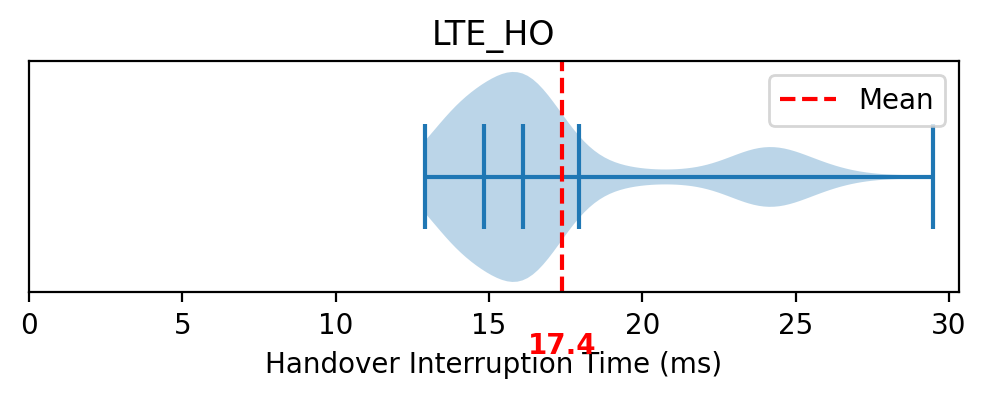

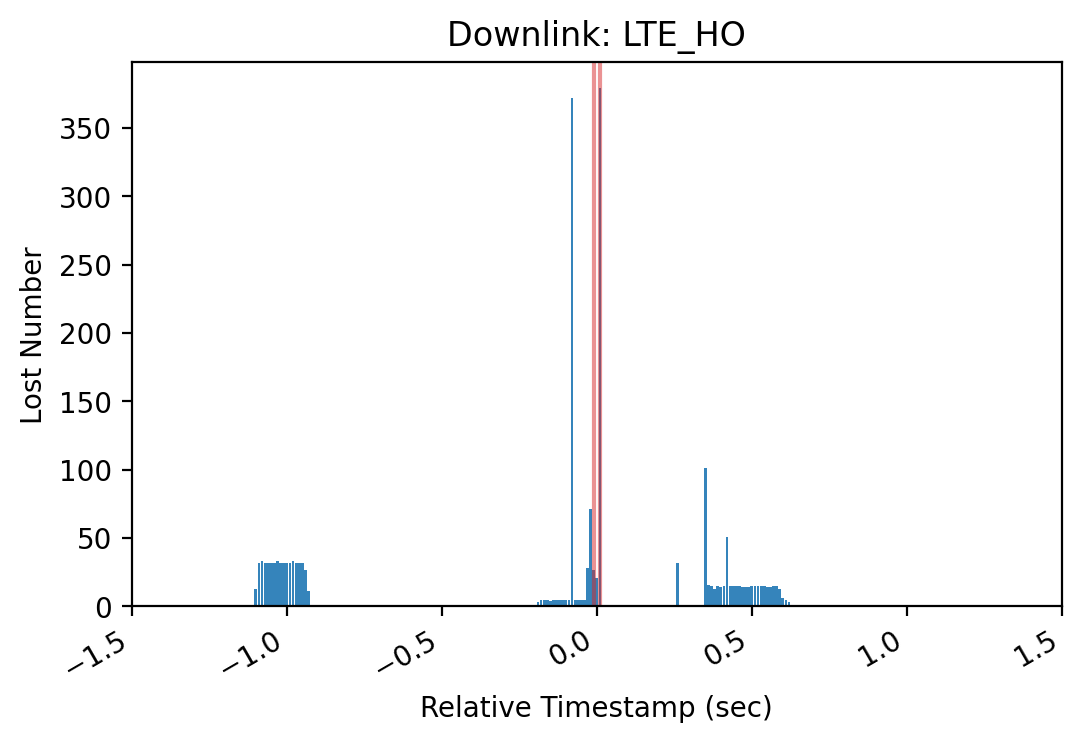

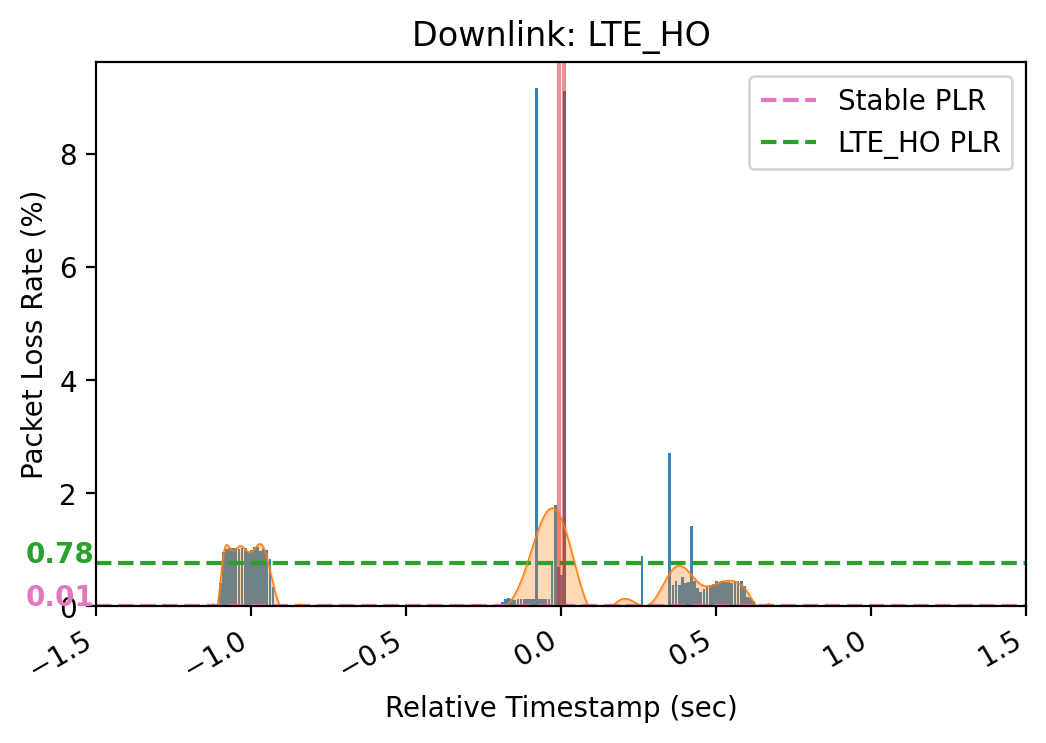

MN_HO
HO Count: 1666
Average Duration: 0.018224502398799053 seconds
Average PLR: 1.3782404950454623 %
Stable PLR: 0.012168573554190753 %


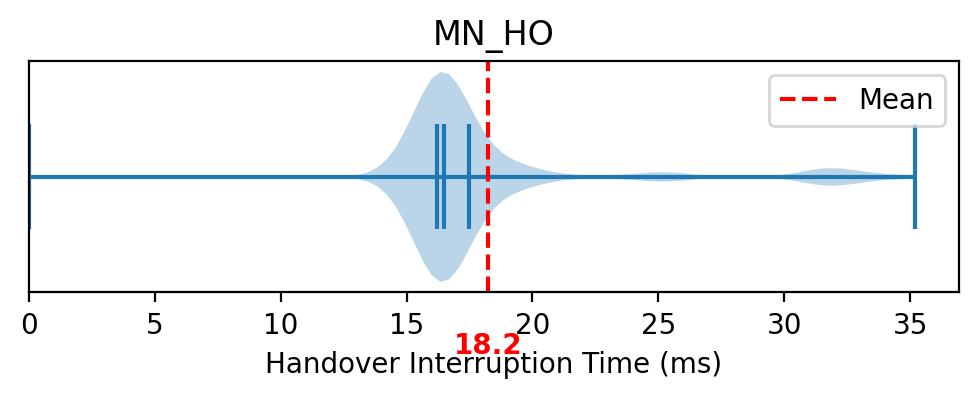

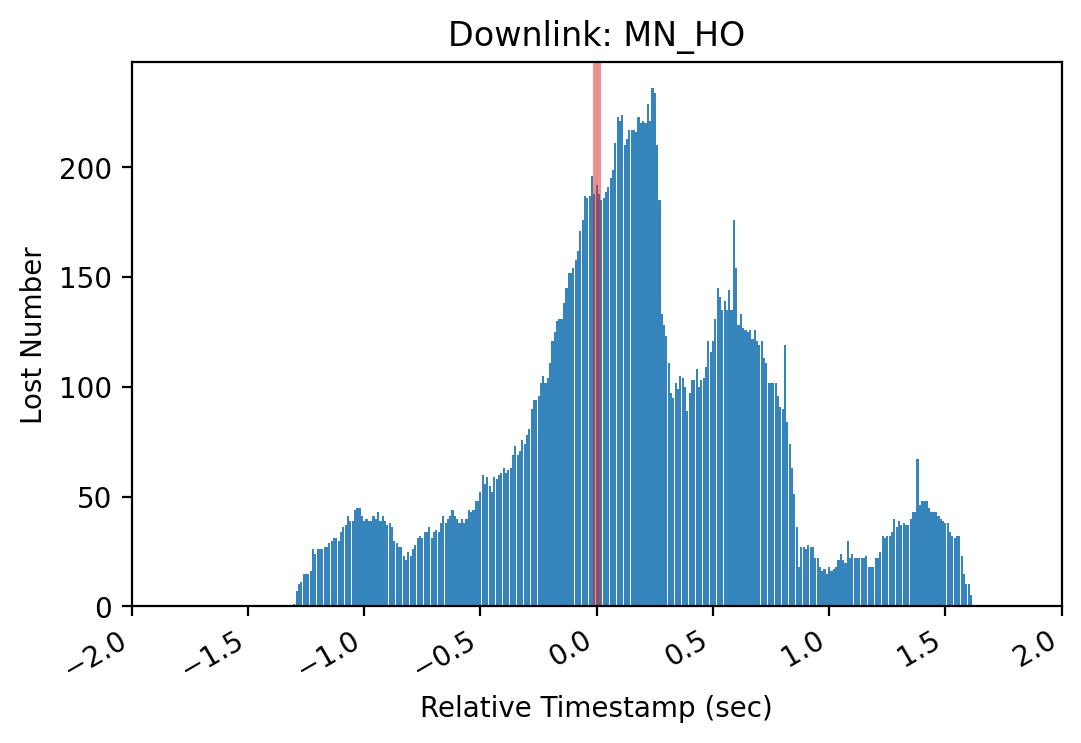

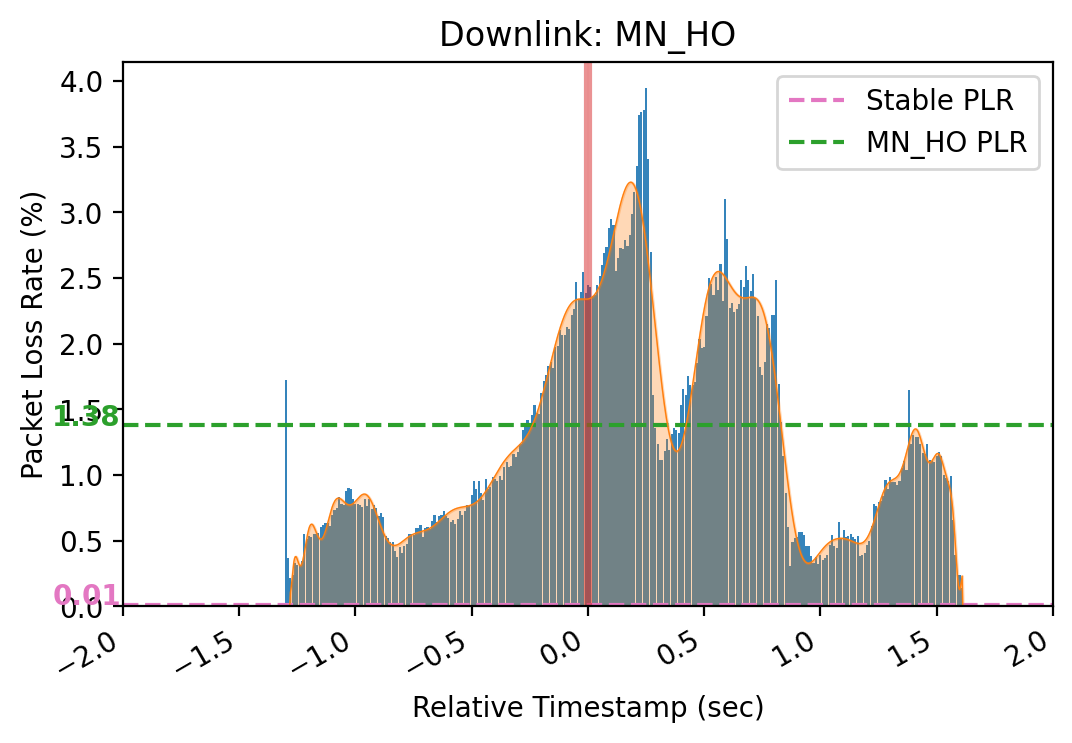

SN_HO
HO Count: 1775
Average Duration: 0.014759946468115693 seconds
Average PLR: 0.45407361132452984 %
Stable PLR: 0.012168573554190753 %


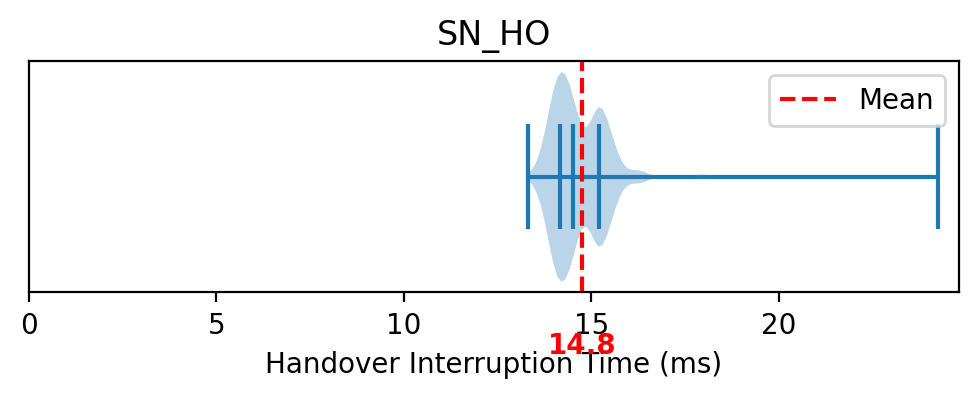

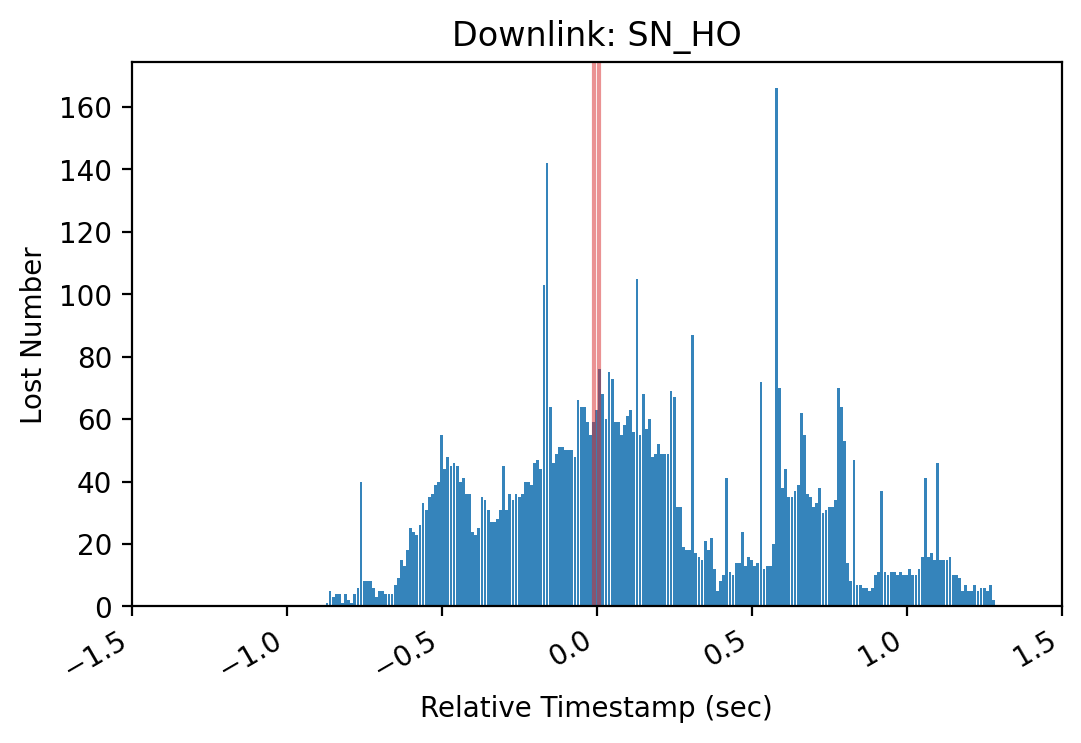

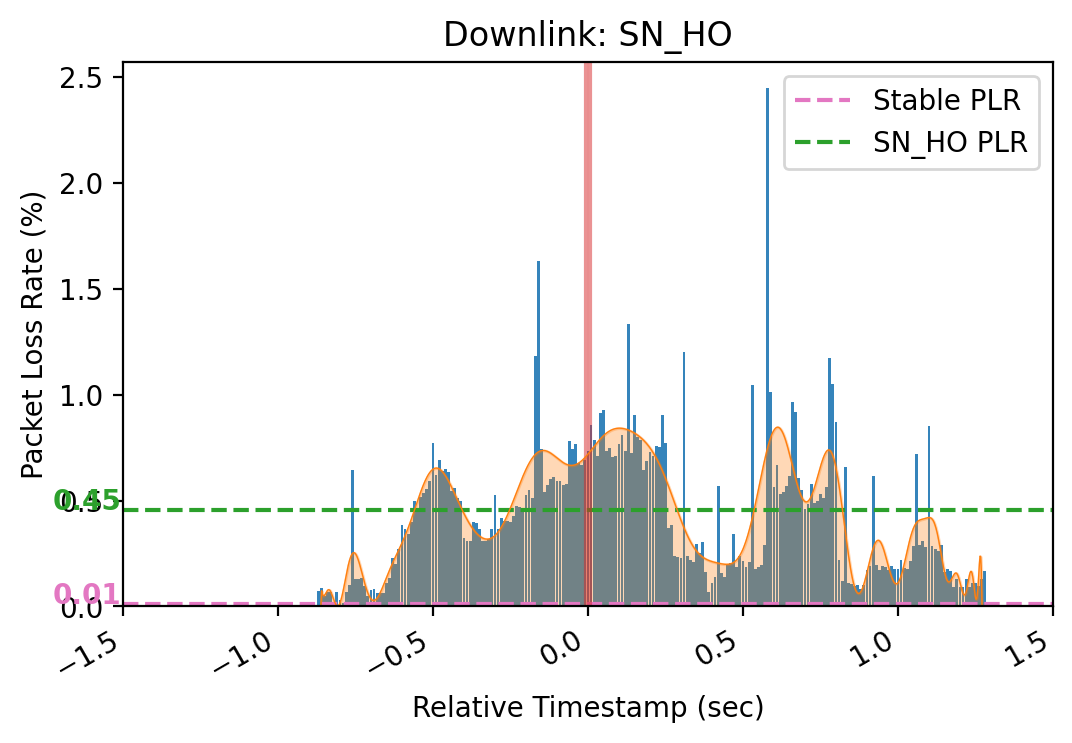

SN_Rel
HO Count: 11
Average Duration: 0.027407454411414536 seconds
Average PLR: 10.094637223958841 %
Stable PLR: 0.012168573554190753 %


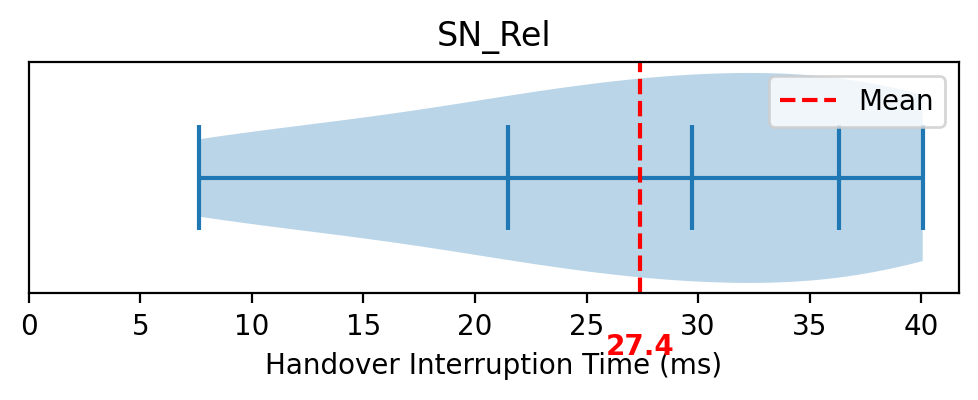

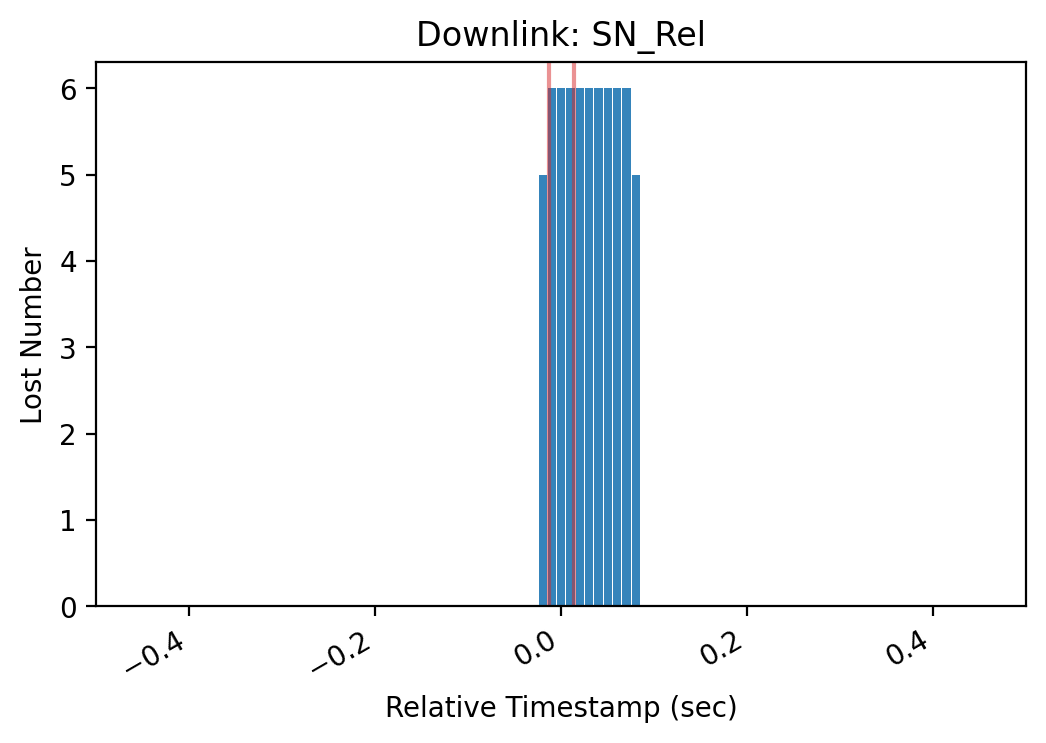

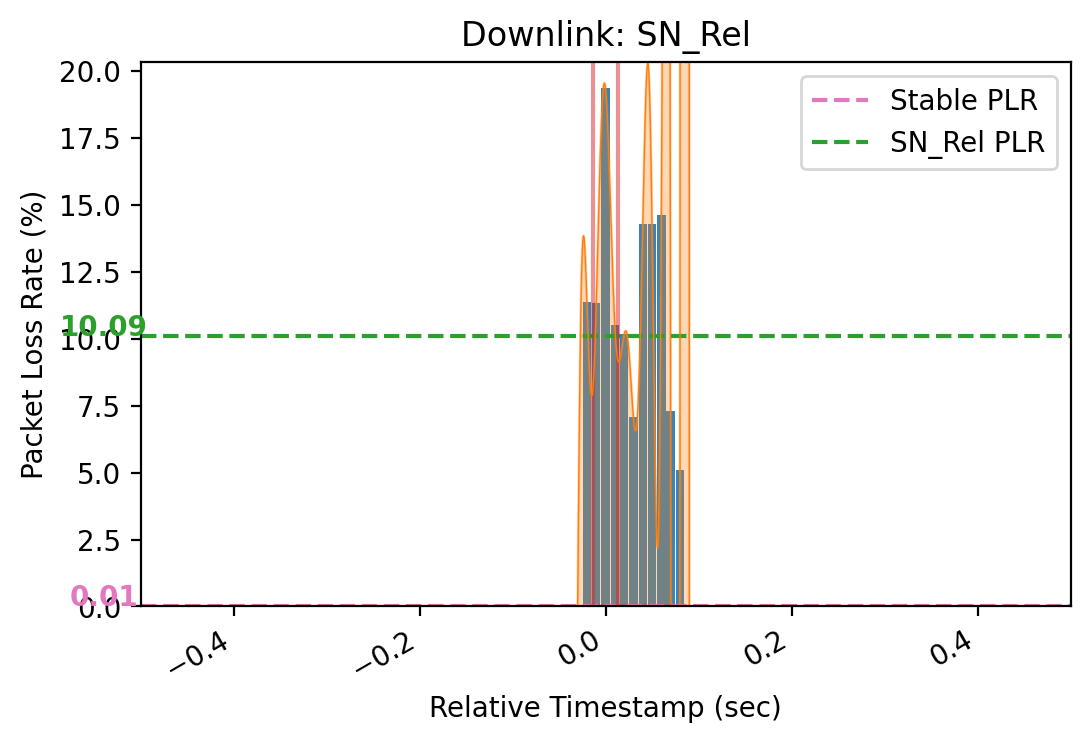

SN_Setup
HO Count: 445
Average Duration: 0.030301943838889345 seconds
Average PLR: 15.99049720738653 %
Stable PLR: 0.012168573554190753 %


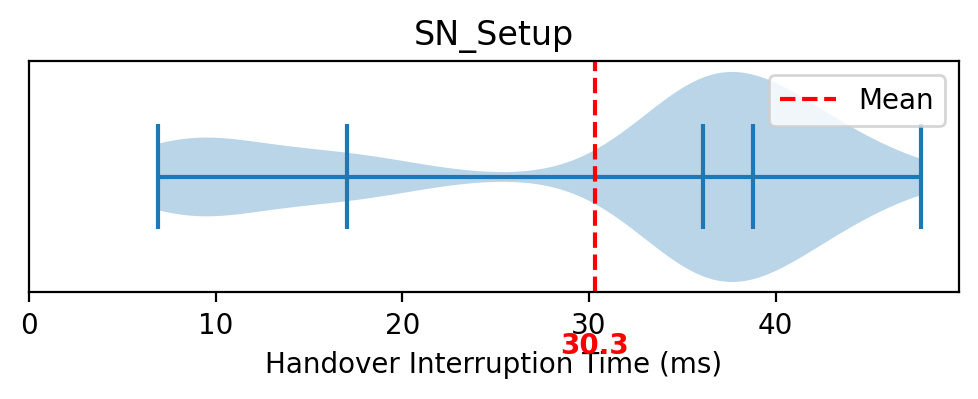

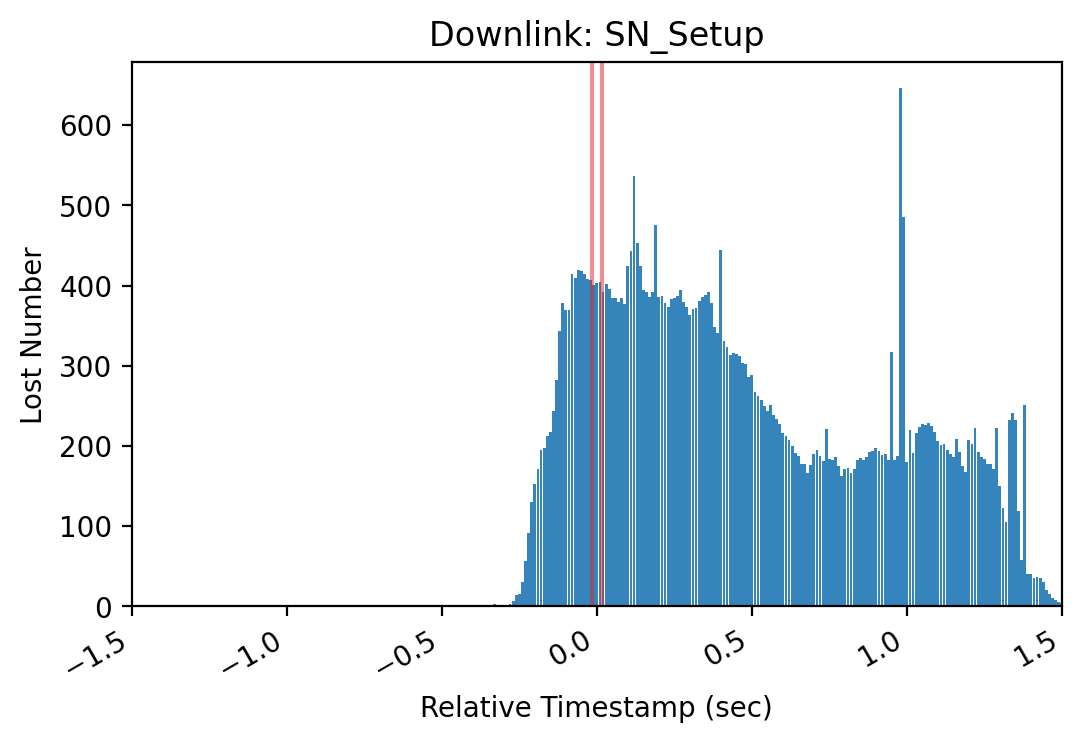

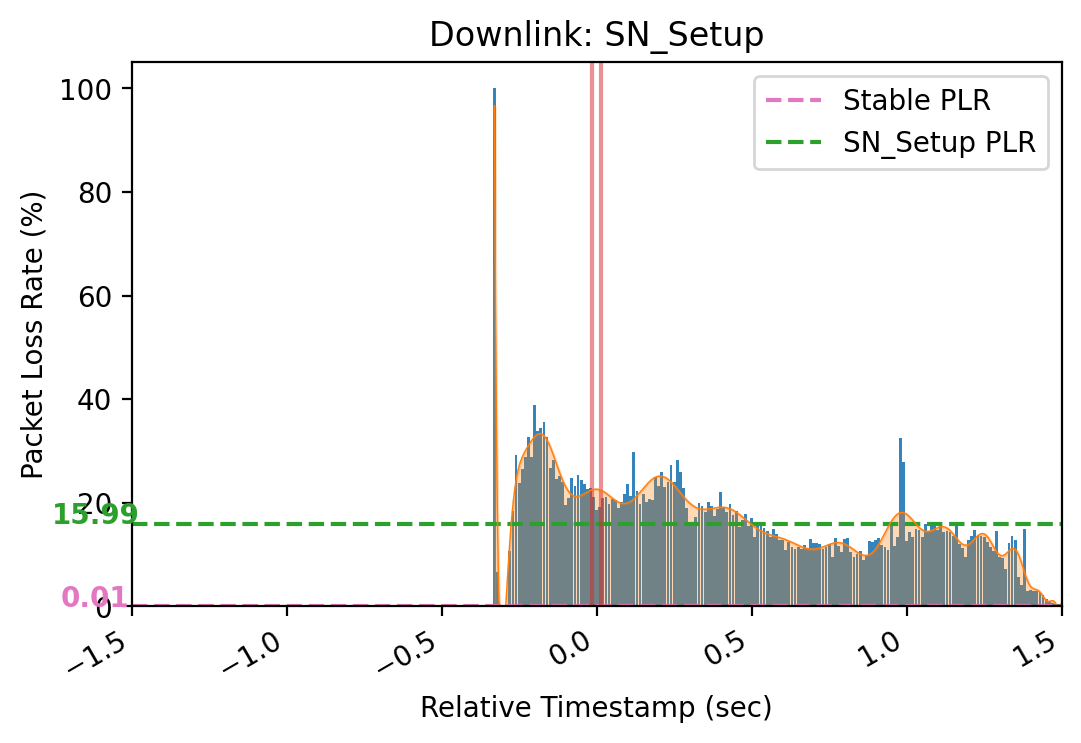

SN_Rel_MN_HO
HO Count: 233
Average Duration: 0.031081978471494028 seconds
Average PLR: 6.7825547105384185 %
Stable PLR: 0.012168573554190753 %


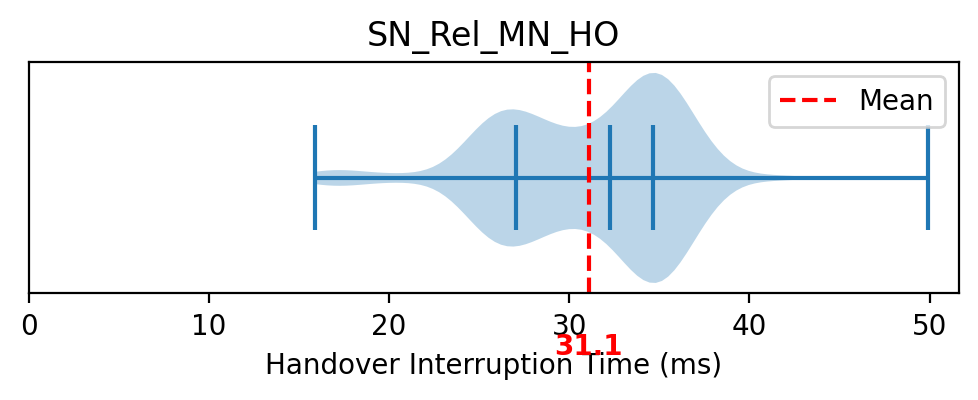

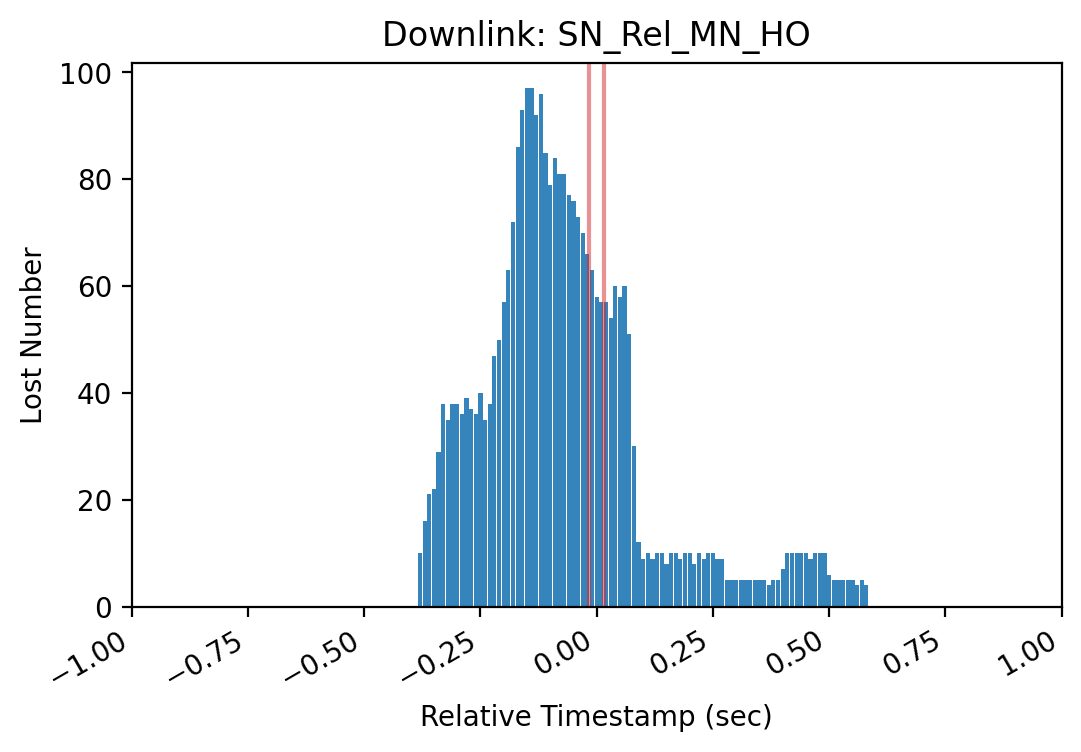

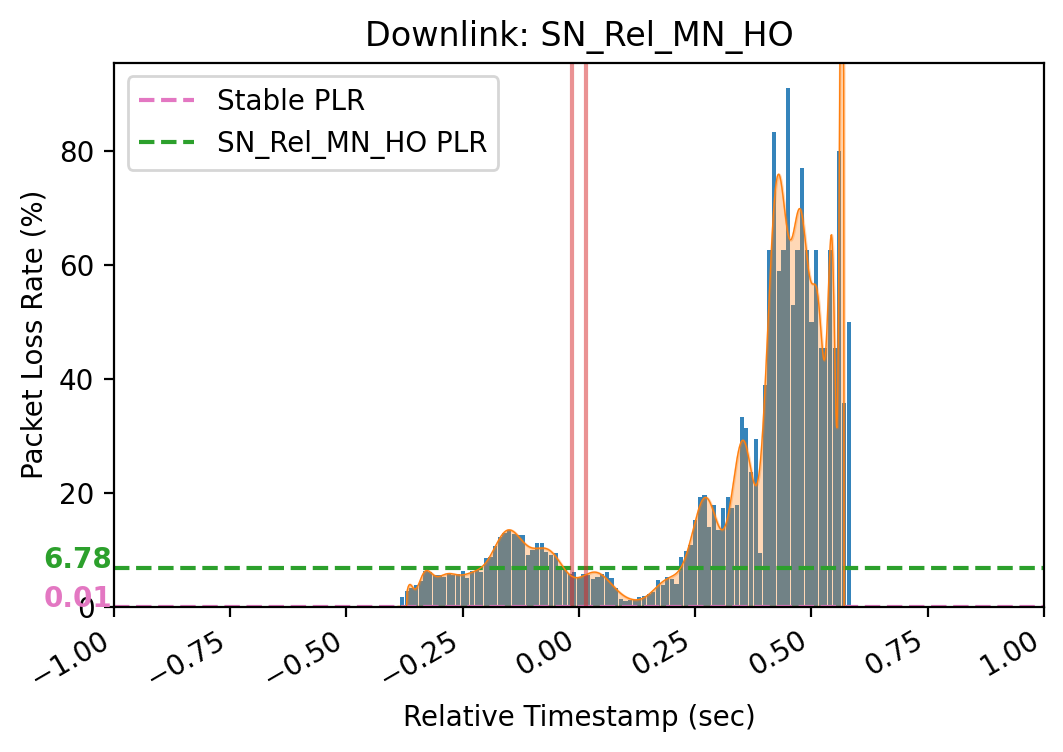

SCG_Failure_t310-Expiry (0)
HO Count: 3
Average Duration: 0.0 seconds
Average PLR: 68.75249103225639 %
Stable PLR: 0.012168573554190753 %


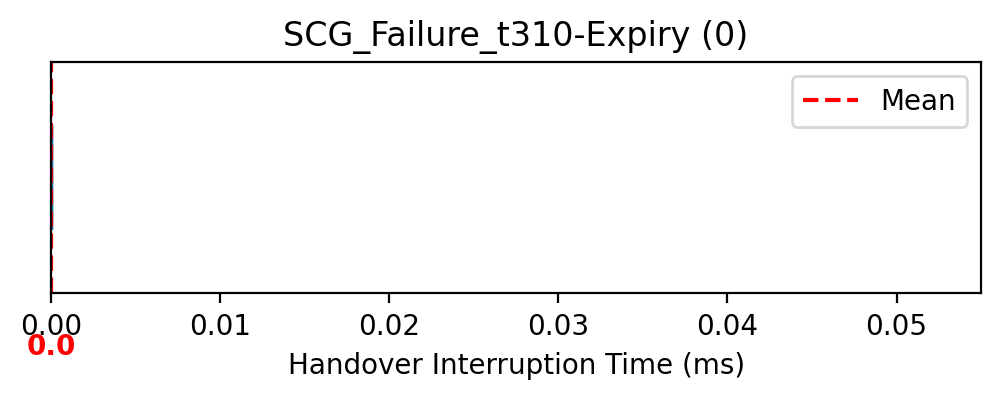

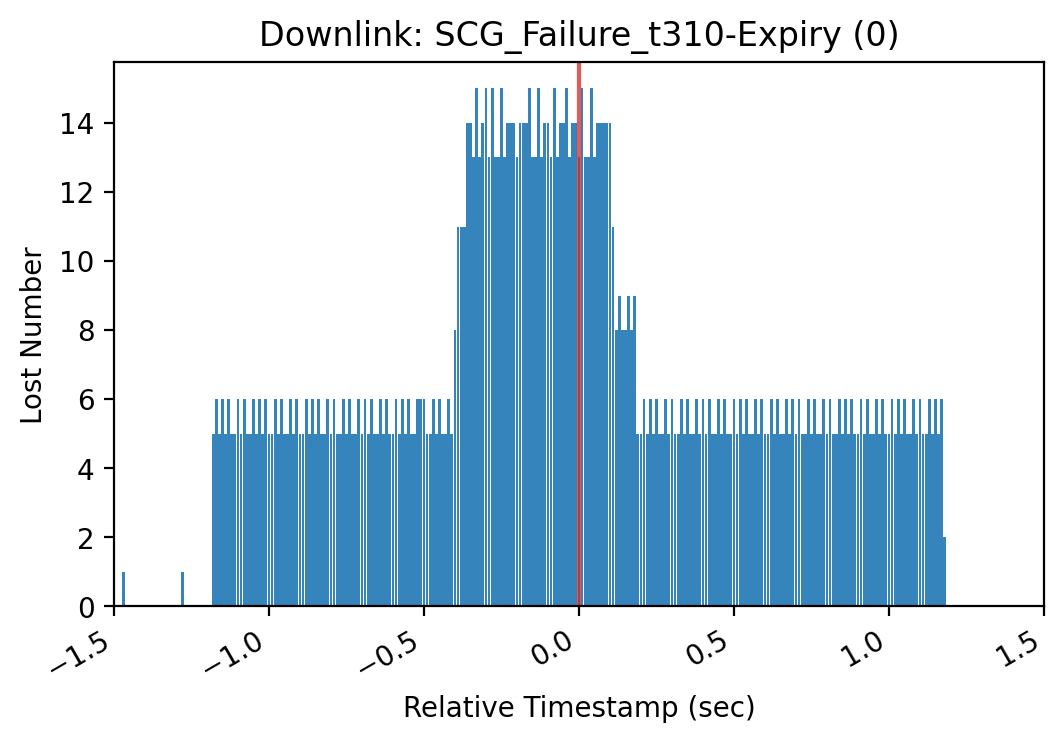

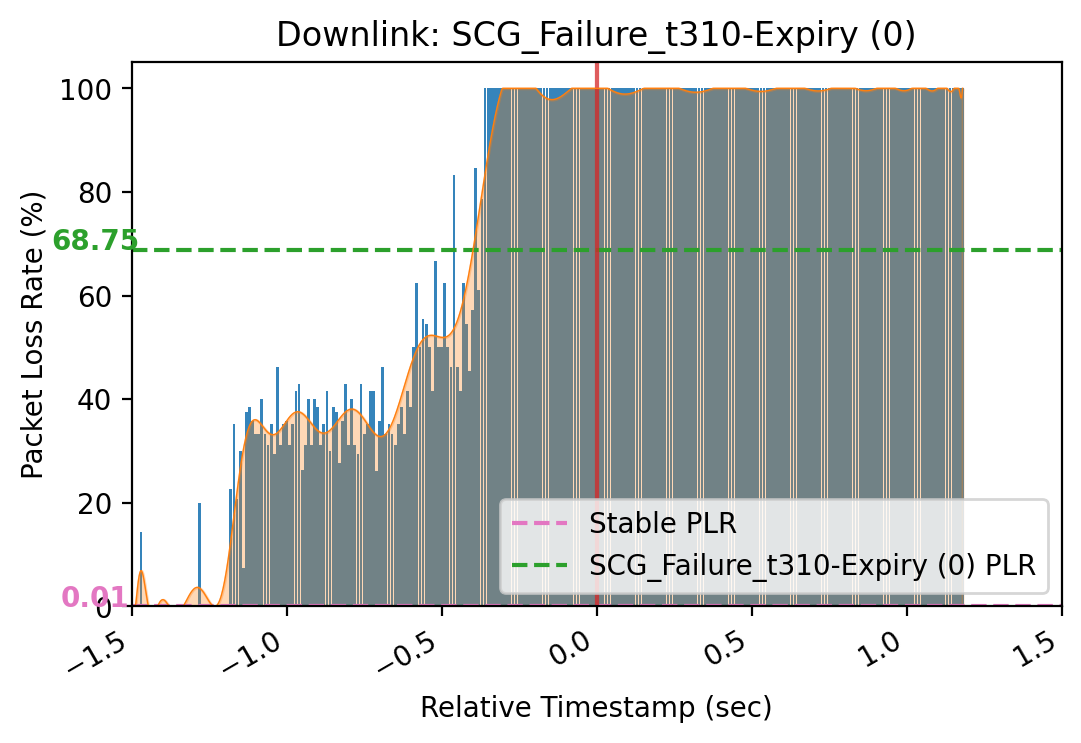

SCG_Failure_synchReconfigFailureSCG (3)
HO Count: 7
Average Duration: 0.0 seconds
Average PLR: 9.895833333281793 %
Stable PLR: 0.012168573554190753 %


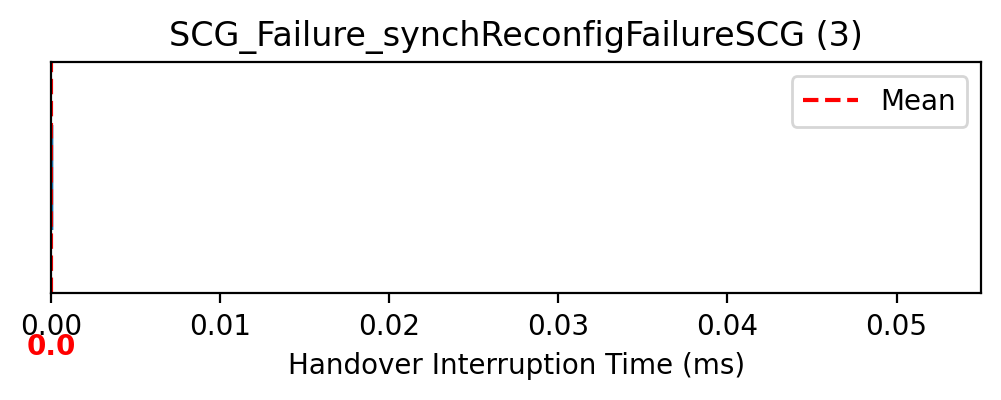

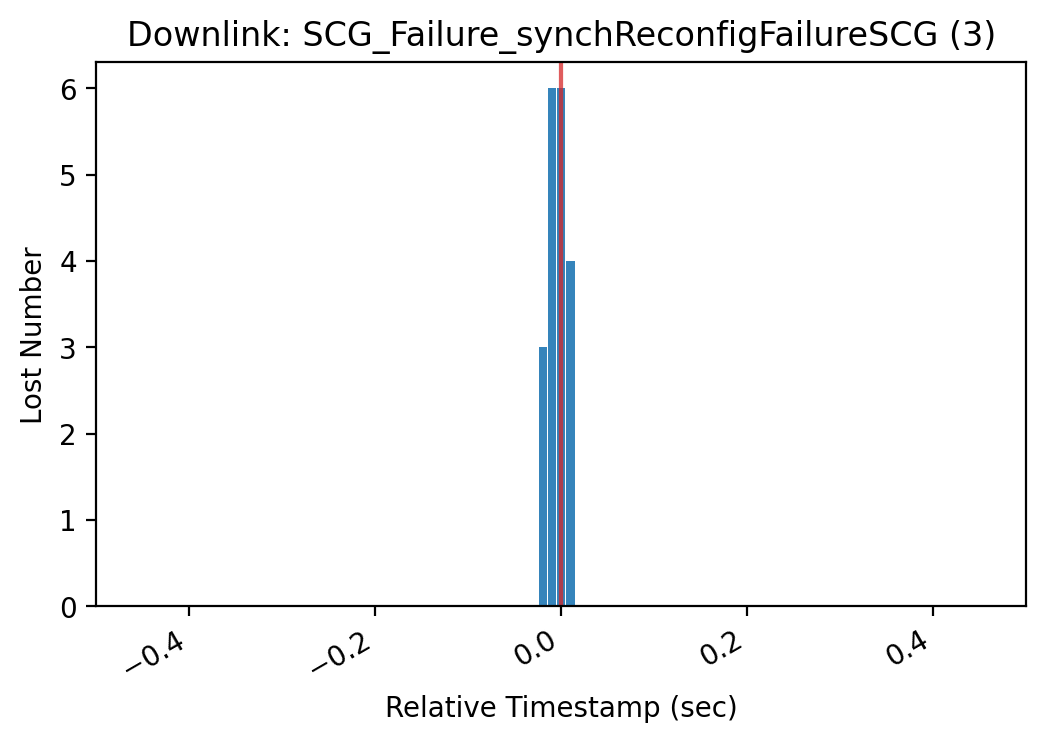

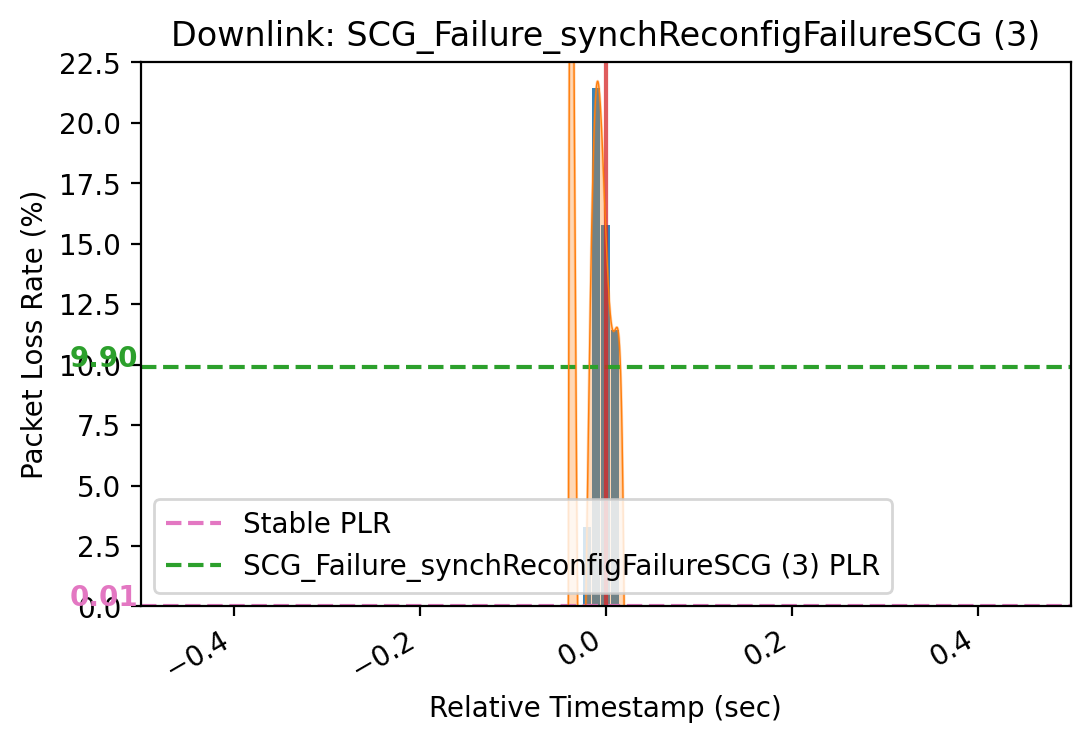

MCG_Failure_handoverFailure (1)
HO Count: 15
Average Duration: 0.08033413365483284 seconds
Average PLR: 67.76646776645984 %
Stable PLR: 0.012168573554190753 %


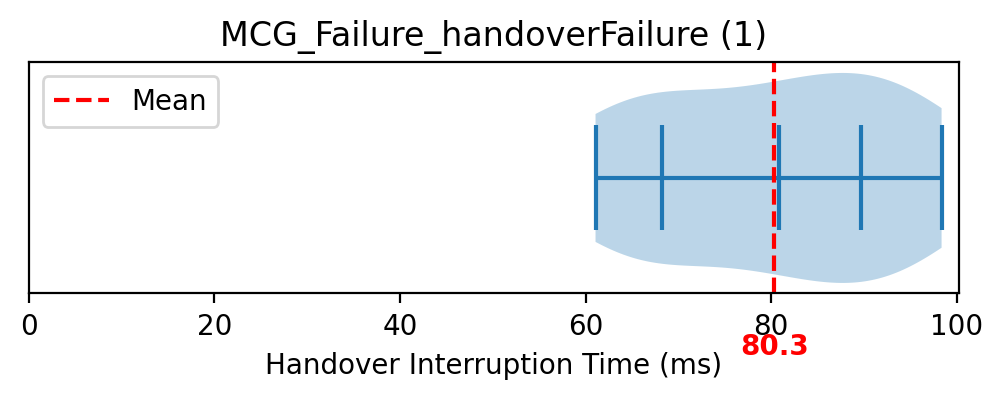

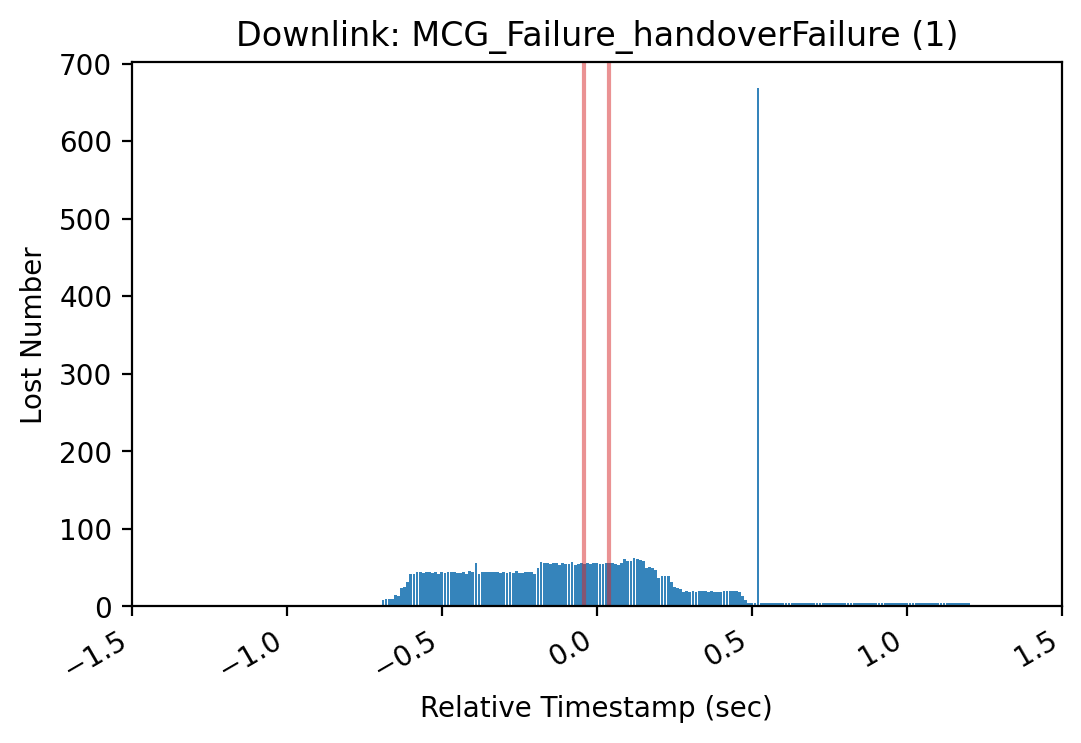

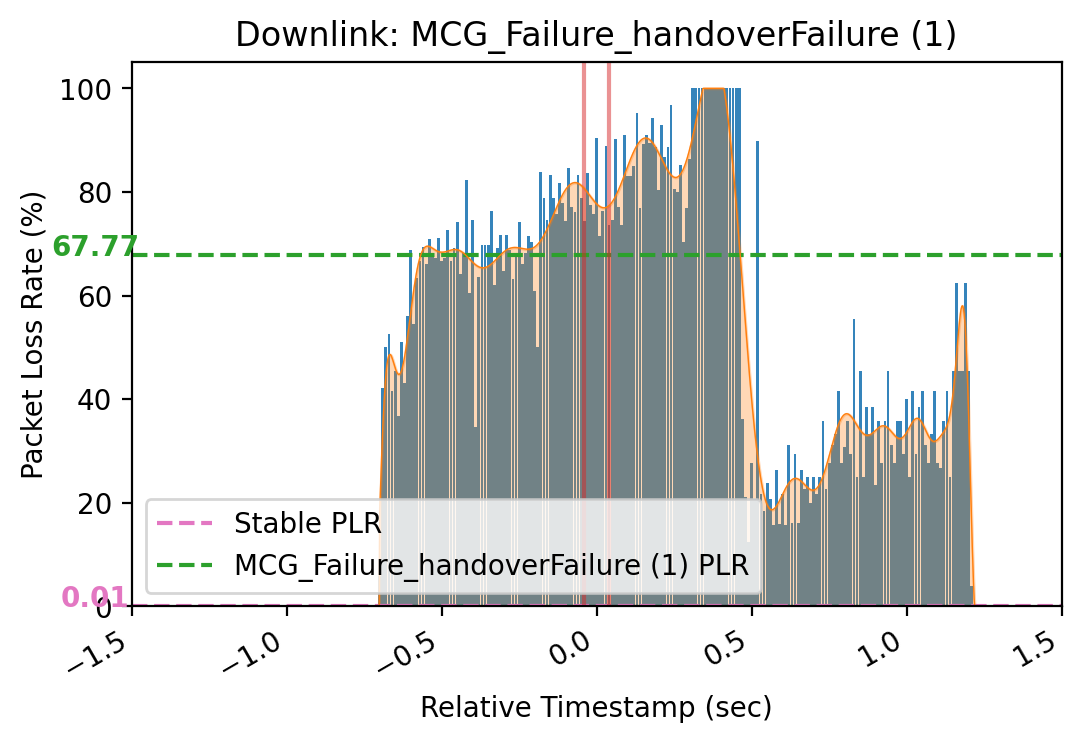

MCG_Failure_otherFailure (2)
HO Count: 214
Average Duration: 0.07793514952759877 seconds
Average PLR: 21.32377775031912 %
Stable PLR: 0.012168573554190753 %


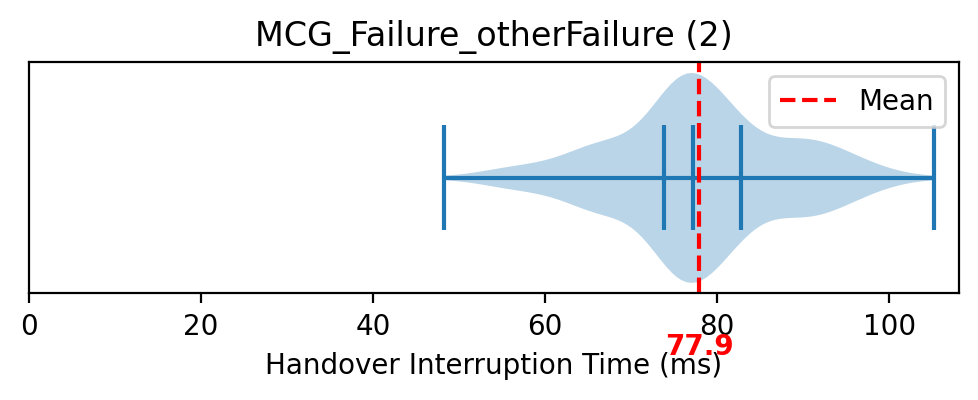

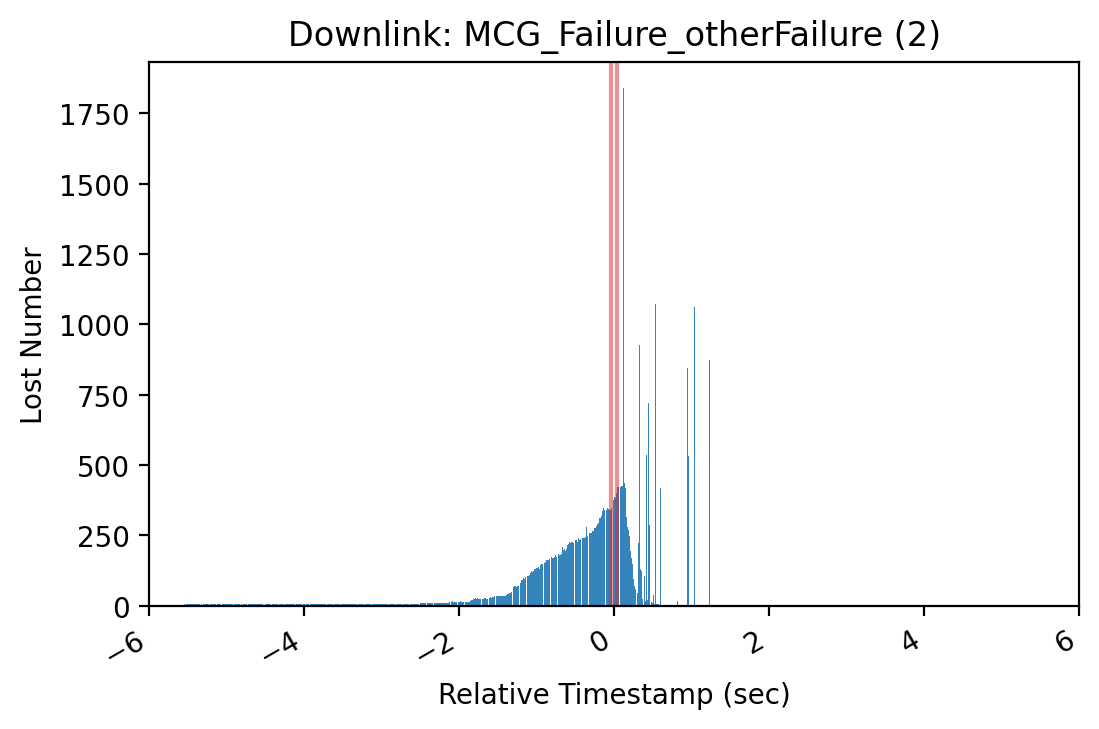

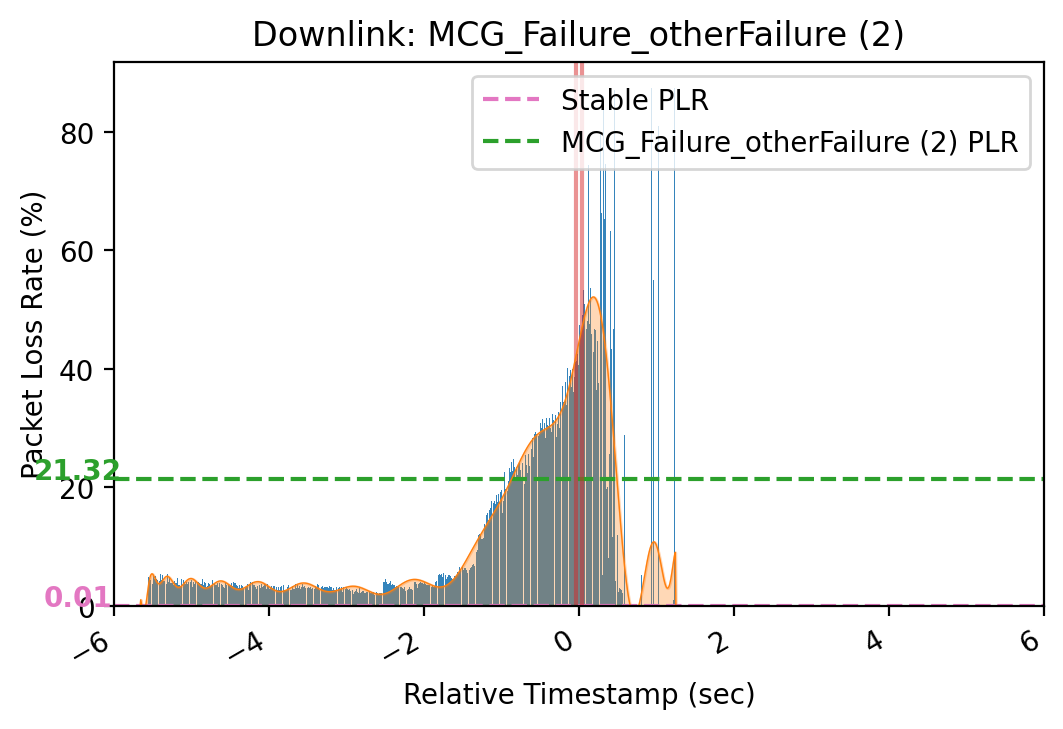

NAS_Recovery_otherFailure (2)
HO Count: 5
Average Duration: 0.3988637953996658 seconds
Average PLR: 56.80722891564554 %
Stable PLR: 0.012168573554190753 %


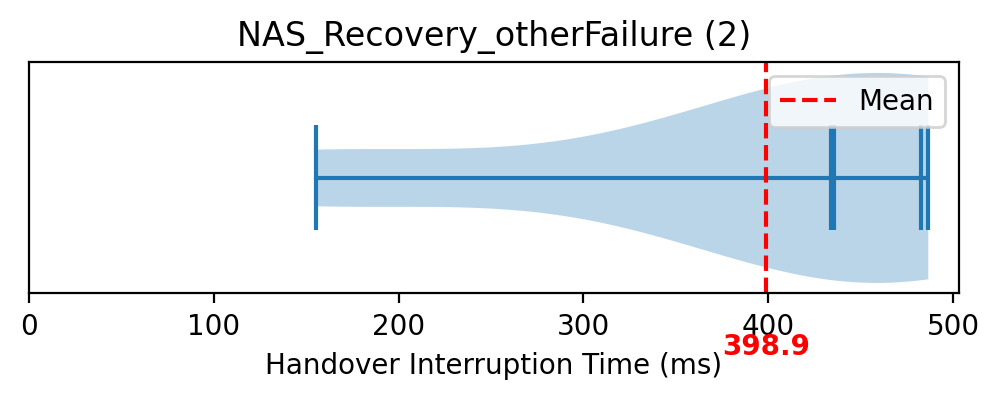

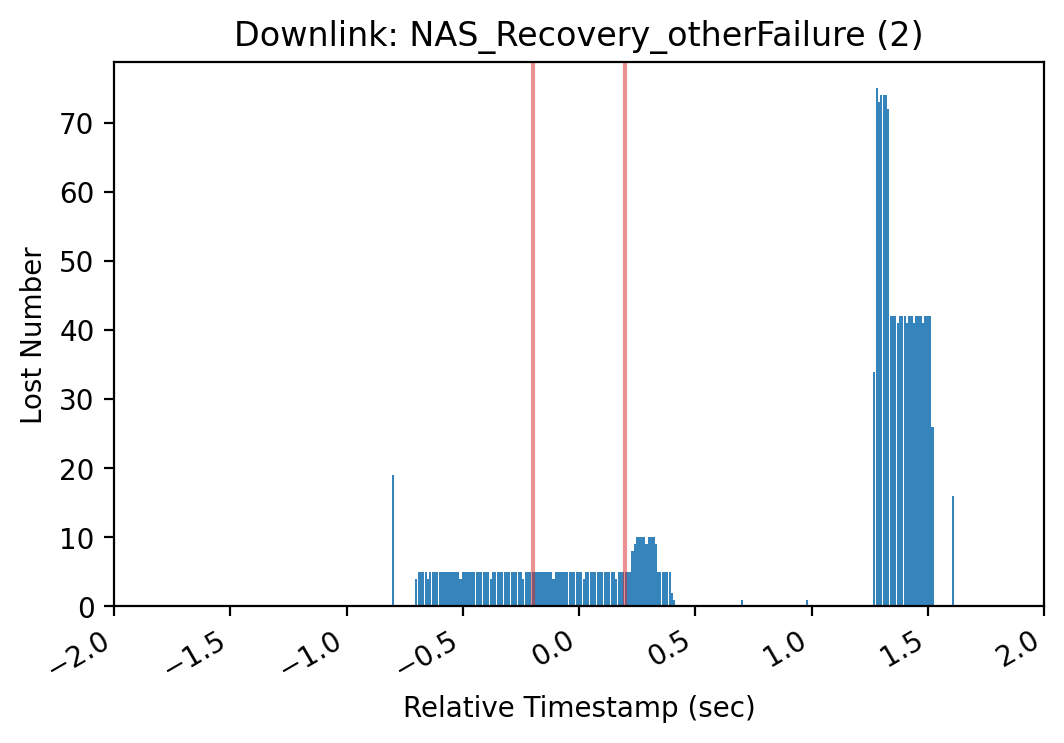

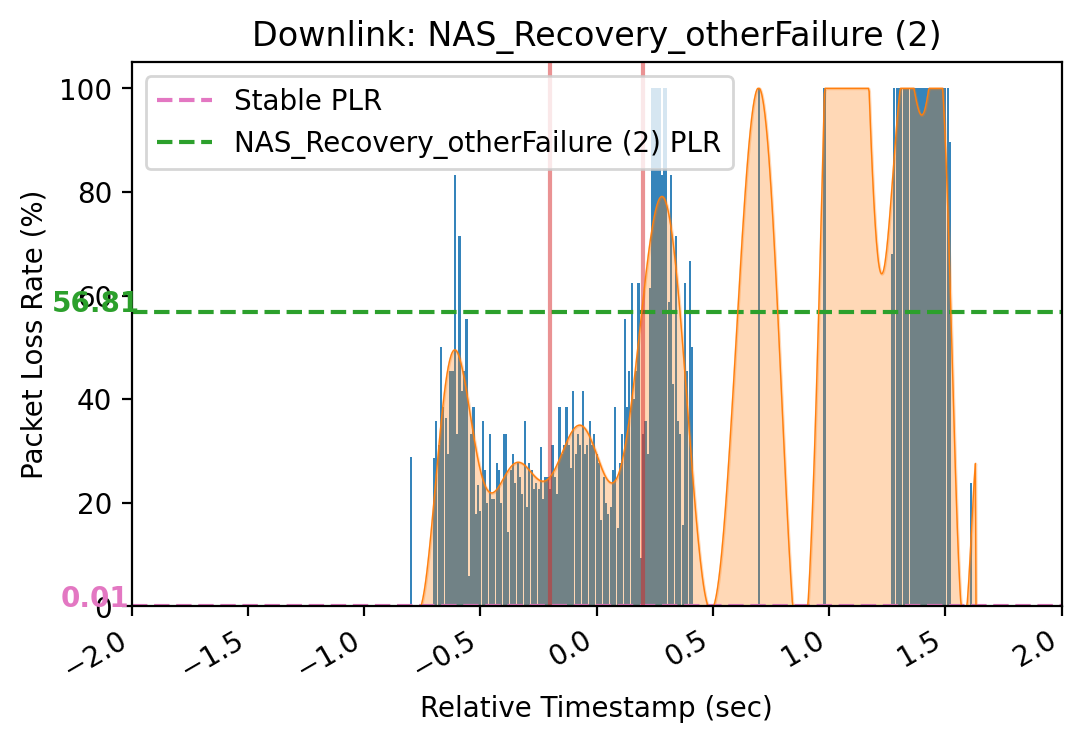

In [5]:
import warnings

def heaviside(x, left, right):
    if x < left:
        return 0
    elif x > right:
        return 0
    else:
        return 1

for tag in sorter:
    if len(D[tag]['intrs']) == 0:
        continue
    print('===================================')
    print(tag)
    table, intr = merge_profile(D[tag]['tables'], D[tag]['intrs'])
    print('HO Count:', sum(D[tag]['count']))
    print('Average Duration:', intr, 'seconds')
    # display(table)
    
    _table = table.query('PLR > @dl_stable_plr').copy().reset_index(drop=True)
    # _table = table.copy().reset_index(drop=True)
    tcount = sum(_table['tx_count'])
    lcount = sum(_table['lost'])
    plr = lcount / (tcount + 1e-9) * 100
    print('Average PLR:', plr, '%')
    print('Stable PLR:', dl_stable_plr, '%')
    
    path = './temp'
    plot_intrs(D[tag]['intrs'], tag, path=path)
    
    xlim = math.ceil(max([s*2 for s in ImpactScope[tag]])) / 2
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_title(f'Downlink: {tag}')
    ax.set_xlim(-xlim, xlim)
    ax.bar(table['cat_id'], table['lost'], width=0.009, alpha=0.9)
    ax.set_ylabel('Lost Number')
    ax.set_ylim(bottom=0)
    _intr = intr / 2
    ax.axvline(-_intr, color='tab:red', alpha=0.5)
    ax.axvline(_intr, color='tab:red', alpha=0.5)
    ax.set_xlabel('Relative Timestamp (sec)')
    plt.gcf().autofmt_xdate()
    plt.savefig(os.path.join(path, f'{tag}_DL_lost.png'), bbox_inches='tight', dpi=300)
    plt.show()
    
    
    xlim = math.ceil(max([s*2 for s in ImpactScope[tag]])) / 2
    # plot_profile(table1, intr=intr1, title=tag, mode='plr', xlim=wsize, path=path, flow='dl', stable_plr=stable_plr, plr=plr, plr1=plr1)
    xlim = math.ceil(max([s*2 for s in ImpactScope[tag]])) / 2
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_title(f'Downlink: {tag}')
    ax.set_xlim(-xlim, xlim)
    ax.bar(table['cat_id'], table['PLR'], width=0.009, alpha=0.9)
    ax.set_ylabel('Packet Loss Rate (%)')
    ax.set_ylim(bottom=0)
    if ax.get_ylim()[1] < 1:
        ax.set_ylim(top=1.05)
    
    ax.axhline(dl_stable_plr, color='tab:pink', linestyle='--', label='Stable PLR')
    ax.text(-1.078*xlim, dl_stable_plr, '{:.2f}'.format(dl_stable_plr), ha='center', fontweight='bold', fontsize=10, color='tab:pink')
    ax.axhline(plr, color='tab:green', linestyle='--', label=f'{tag} PLR')
    ax.text(-1.078*xlim, plr, '{:.2f}'.format(plr), ha='center', fontweight='bold', fontsize=10, color='tab:green')
    ax.legend()
    bleft = -ImpactScope[tag][0]
    bright = ImpactScope[tag][1]
    
    _intr = intr / 2
    ax.axvline(-_intr, color='tab:red', alpha=0.5)
    ax.axvline(_intr, color='tab:red', alpha=0.5)
    ax.set_xlabel('Relative Timestamp (sec)')
    
    x = np.asarray(table['cat_id'], dtype=np.float64)
    y = np.asarray(table['PLR'], dtype=np.float64)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', np.RankWarning)
        z = np.polyfit(x, y, 70)
        p = np.poly1d(z)
    xp = np.linspace(table['cat_id'].iloc[0], table['cat_id'].iloc[-1], 1000)
    
    ax.plot(xp, np.clip(p(xp)*np.vectorize(heaviside)(xp, bleft, bright), a_min=0, a_max=100), '-', c='tab:orange', lw=0.5)
    ax.fill_between(xp, np.clip(p(xp)*np.vectorize(heaviside)(xp, bleft, bright), a_min=0, a_max=100), color='tab:orange', alpha=0.3)
    
    plt.gcf().autofmt_xdate()
    plt.savefig(os.path.join(path, f'{tag}_DL_PLR.png'), bbox_inches='tight', dpi=300)
    plt.show()

## Uplink

### Transmission Time

In [6]:
ImpactScope = {
    'LTE_HO': (1.15, 0.7),
    'MN_HO': (1.2, 2),
    'SN_HO': (0.85, 1.25),
    'SN_Setup': (0.4, 1.7),
    'SN_Rel': (0.2, 0.2),
    'SN_Rel_MN_HO': (0.55, 0.55),
    'SCG_Failure_t310-Expiry (0)': (1.3, 1.21),
    'SCG_Failure_synchReconfigFailureSCG (3)': (0.05, 0.05),
    'MCG_Failure_reconfigurationFailure (0)': (2, 2),
    'MCG_Failure_handoverFailure (1)': (0.8, 1.25),
    'MCG_Failure_otherFailure (2)': (15 , 8.5),
    'NAS_Recovery_otherFailure (2)': (0.75, 1.6)
}

# ImpactScope = {
#     'LTE_HO': (5, 5),
#     'MN_HO': (5, 5),
#     'SN_HO': (5, 5),
#     'SN_Setup': (2, 2),
#     'SN_Rel': (2, 2),
#     'SN_Rel_MN_HO': (1, 1),
#     'SCG_Failure_t310-Expiry (0)': (2, 2),
#     'SCG_Failure_synchReconfigFailureSCG (3)': (0.5, 0.5),
#     'MCG_Failure_reconfigurationFailure (0)': (2, 2),
#     'MCG_Failure_handoverFailure (1)': (1.5, 1.5),
#     'MCG_Failure_otherFailure (2)': (10, 10),
#     'NAS_Recovery_otherFailure (2)': (2, 2)
# }

datadir = "/Users/jackbedford/Desktop/MOXA/Code/data"
# datadir = "/home/wmnlab/D/database"
exps = {
    "2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(12)],
    "2023-04-01/_Bandlock_Udp_B1_B3_B7_B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(6)],
    "2023-04-01/_Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(4)],
    "2023-04-17/_Bandlock_Udp_All_LTE_B1B3_B3B7_RM500Q": ['#{:02d}'.format(i+1) for i in range(2)],
    "2023-04-17/_Bandlock_Udp_All_LTE_B1B7_B7B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(4)],
    "2023-04-17/_Bandlock_Udp_All_LTE_B1B8_B3B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(4)],
    "2023-04-17/_Bandlock_Udp_All_LTE_All_LTE_RM500Q": ['#{:02d}'.format(i+1) for i in range(4)],
    "2023-04-17/_Bandlock_Udp_All_LTE_B1_B3_RM500Q": ['#{:02d}'.format(i+1) for i in range(2)],
    "2023-04-17/_Bandlock_Udp_All_LTE_B7_B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(2)],
}
_devices = [
    ['qc00','qc02','qc03'],
    ['qc00','qc01','qc02','qc03'],
    ['qc00','qc01','qc02','qc03'],
    ['qc00','qc01','qc02','qc03'],
    ['qc00','qc01','qc02','qc03'],
    ['qc00','qc01','qc02','qc03'],
    ['qc00','qc01','qc02','qc03'],
    ['qc00','qc01','qc02','qc03'],
    ['qc00','qc01','qc02','qc03'],
]
_schemes = [
    ['B1','B7','B8'],
    ['B1','B3','B7','B8'],
    ['B1B3','B1B8','LTE','All'],
    ['All','LTE','B1B3','B3B7'],
    ['All','LTE','B1B7','B7B8'],
    ['All','LTE','B1B8','B3B8'],
    ['All0','LTE1','All2','LTE3'],
    ['All','LTE','B1','B3'],
    ['All','LTE','B7','B8'],
]

In [7]:
sorter = ['LTE_HO','MN_HO','SN_HO','MNSN_HO','SN_Rel','SN_Setup','SN_Rel_MN_HO','SN_Setup_MN_HO',
          'SCG_Failure_t310-Expiry (0)','SCG_Failure_randomAccessProblem (1)','SCG_Failure_rlc-MaxNumRetx (2)','SCG_Failure_synchReconfigFailureSCG (3)',
          'SCG_Failure_scg-ReconfigFailure (4)','SCG_Failure_srb3-IntegrityFailure (5)','SCG_Failure_other-r16 (6)',
          'MCG_Failure_reconfigurationFailure (0)','MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
          'NAS_Recovery_reconfigurationFailure (0)','NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)']

U = {}
for tag in sorter:
    U[tag] = {'tables': [], 'intrs': [], 'count': []}
ul_stable_pkt = 0
ul_stable_loss = 0
for (exp, traces), devices, schemes in zip(exps.items(), _devices, _schemes):
    for trace in traces:
        for j, (dev, schm) in enumerate(zip(devices, schemes)):
            ## read downlink
            data = os.path.join(datadir, exp, dev, trace, 'data', 'udp_uplk_loss_latency.csv')
            print(data, os.path.isfile(data))
            df_ul = pd.read_csv(data)
            df_ul = set_data(df_ul)
            ## read handover
            path = os.path.join(datadir, exp, dev, trace, 'data')
            data = os.path.join(path, [s for s in os.listdir(path) if s.startswith('diag_log_') and s.endswith('_rrc.csv')][0])
            print(data, os.path.isfile(data))
            df_ho = pd.read_csv(data)
            df_ho, _, _ = mi_parse_ho(df_ho, tz=8)
            df_ho['ho_type0'] = df_ho['ho_type'].astype('string')
            df_ho.loc[df_ho['cause'].notna(), 'ho_type0'] = df_ho['ho_type'].astype('string') + '_' + df_ho['cause'].astype('string')
            df_ho['ho_type0'] = df_ho['ho_type0'].astype('category')
            ## start processing
            df = df_ho[~np.in1d(df_ho['ho_type'], ['Conn_Setup', 'Conn_Rel'])].copy().reset_index(drop=True)
            A = {}
            for tag in sorter:
                A[tag] = {'tables': [], 'intrs': []}
            _intv = P.singleton(pd.Timestamp.min)
            for i, row in df.iterrows():
                prior_row = df.iloc[i-1] if i != 0 else None
                post_row = df.iloc[i+1] if i != len(df)-1 else None
                ### peek the next event: avoid MN/LTE HO overlaps with handoverFailure
                if i != len(df)-1 and pd.notna(row.end) and row.end > post_row.start:
                    print(i, row.start, row.end, row.ho_type, row.cause)
                    print(i+1, post_row.start, post_row.end, post_row.ho_type, post_row.cause)
                    continue
                if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                    prior_row = df.iloc[i-2] if i > 1 else None
                ### basic timestamp
                tag = row.ho_type0
                start, end = row.start, row.end
                intr = row.intr if pd.notna(row.intr) else 0
                ### set left, right limit
                if prior_row is not None:
                    if pd.notna(prior_row.end):
                        # left = prior_row.end
                        left = prior_row.end + (start - prior_row.end) / 2
                    else:
                        # left = prior_row.start
                        left = prior_row.start + (start - prior_row.start) / 2
                else:
                    left = pd.Timestamp.min
                if post_row is not None:
                    if pd.notna(end):
                        # right = post_row.start
                        right = end + (post_row.start - end) / 2
                    else:
                        # right = post_row.start
                        right = start + (post_row.start - start) / 2
                else:
                    right = pd.Timestamp.max
                ### Setup profile
                table, intv = setup_profile(df_ul, tag, start, end, mode='ul', left=left, right=right)
                # print(intr)
                # display(table)
                A[tag]['tables'].append(table)
                A[tag]['intrs'].append(intr)
                ### count stable loss, pkt (1)
                if i == 0:
                    lower = pd.Timestamp.min
                    upper = intv.lower
                else:
                    lower = _intv.upper
                    upper = intv.lower
                df_tmp = df_ul.query('xmit_time > @lower & xmit_time <= @upper').copy().reset_index(drop=True)
                ul_stable_pkt += len(df_tmp)
                ul_stable_loss += sum(df_tmp['lost'])
                _intv = intv
            ### count stable loss, pkt (2)
            lower = _intv.upper
            upper = pd.Timestamp.max
            df_tmp = df_ul.query('xmit_time > @lower & xmit_time <= @upper').copy().reset_index(drop=True)
            ul_stable_pkt += len(df_tmp)
            ul_stable_loss += sum(df_tmp['lost'])
            for tag in sorter:
                if len(A[tag]['tables']) == 0:
                    continue
                table, intr = merge_profile(A[tag]['tables'], A[tag]['intrs'])
                # print('HO Count:', len(df))
                U[tag]['tables'].append(table)
                U[tag]['intrs'] = [*U[tag]['intrs'], *A[tag]['intrs']]
                U[tag]['count'].append(len(A[tag]['tables']))
            ul_stable_plr = ul_stable_loss / (ul_stable_pkt + 1e-9) * 100
            print(ul_stable_loss, ul_stable_pkt, round(ul_stable_plr, 3))

/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#01/data/udp_uplk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#01/data/diag_log_qc00_2023-03-16_19-23-29_rrc.csv True
0 115590 0.0
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc02/#01/data/udp_uplk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc02/#01/data/diag_log_qc02_2023-03-16_19-23-29_rrc.csv True
3 216534 0.001
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc03/#01/data/udp_uplk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc03/#01/data/diag_log_qc03_2023-03-16_19-23-29_rrc.csv True
3 311863 0.001
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#02/data/udp_uplk_loss_latency.c

### Plot

LTE_HO
HO Count: 801
Average Duration: 0.017398339568331523 seconds
Average PLR: 0.3194292948192257 %
Stable PLR: 0.13538547640672455 %


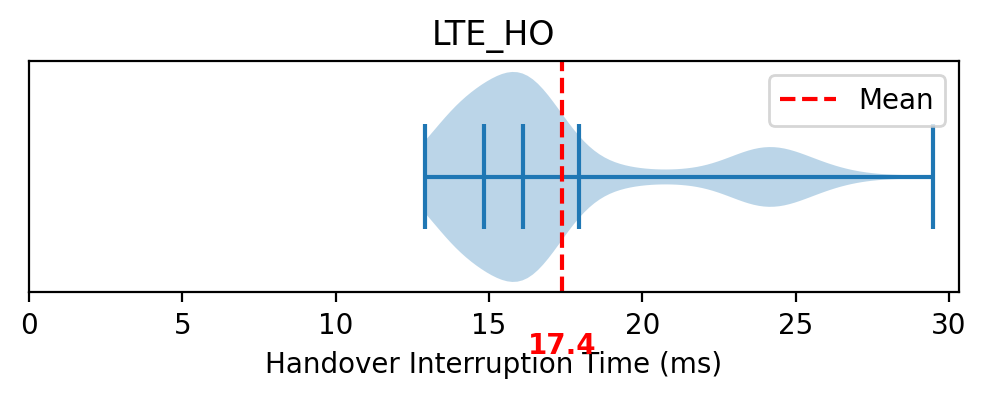

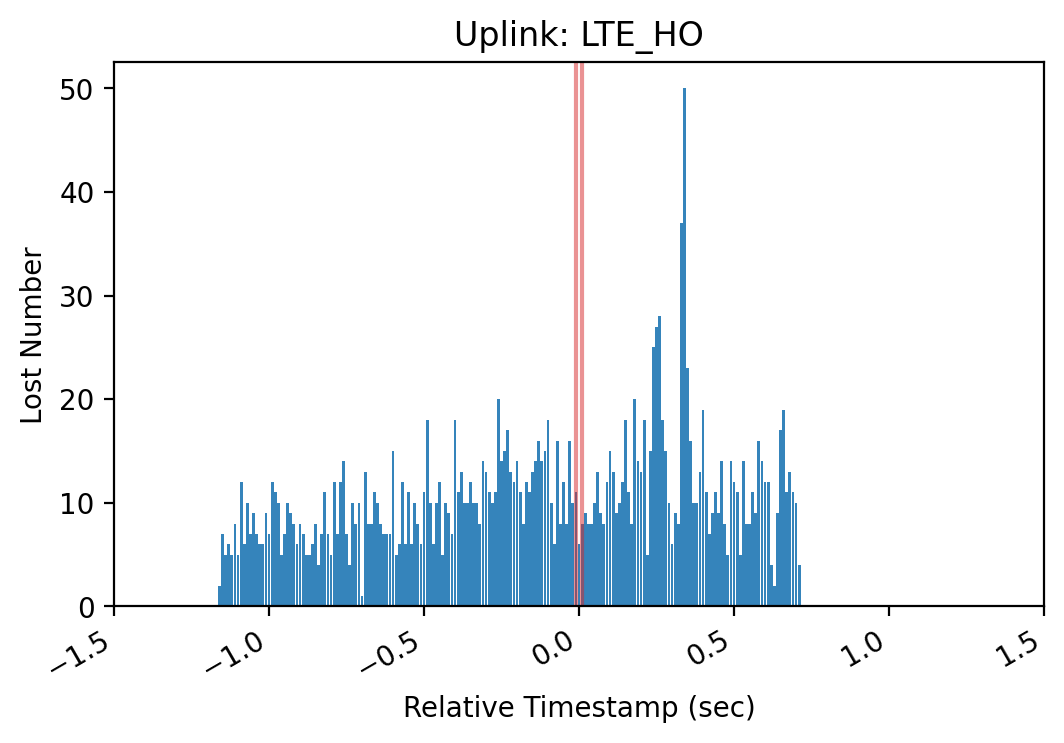

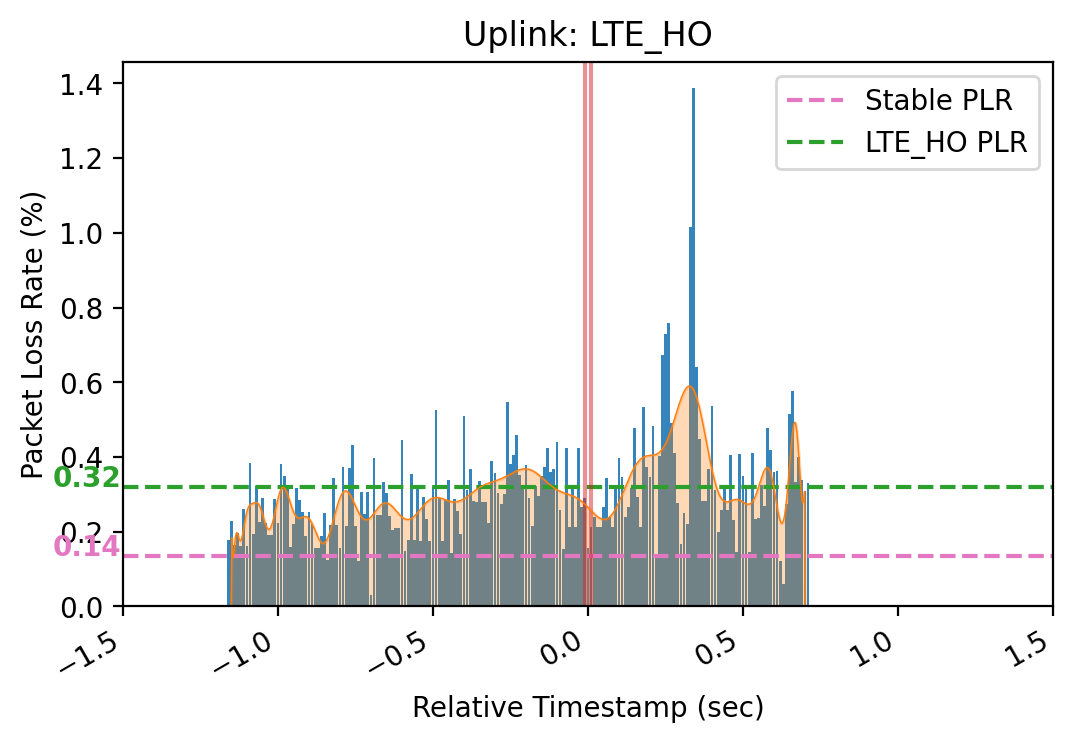

MN_HO
HO Count: 1666
Average Duration: 0.018224502398799053 seconds
Average PLR: 0.3176713821235853 %
Stable PLR: 0.13538547640672455 %


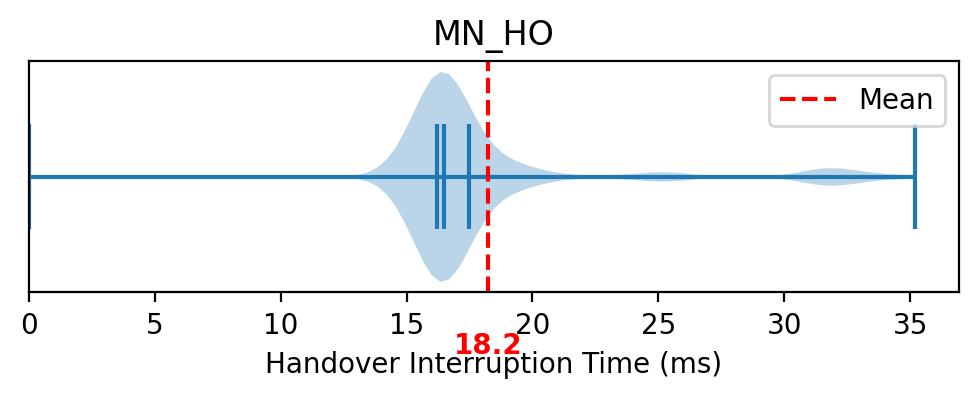

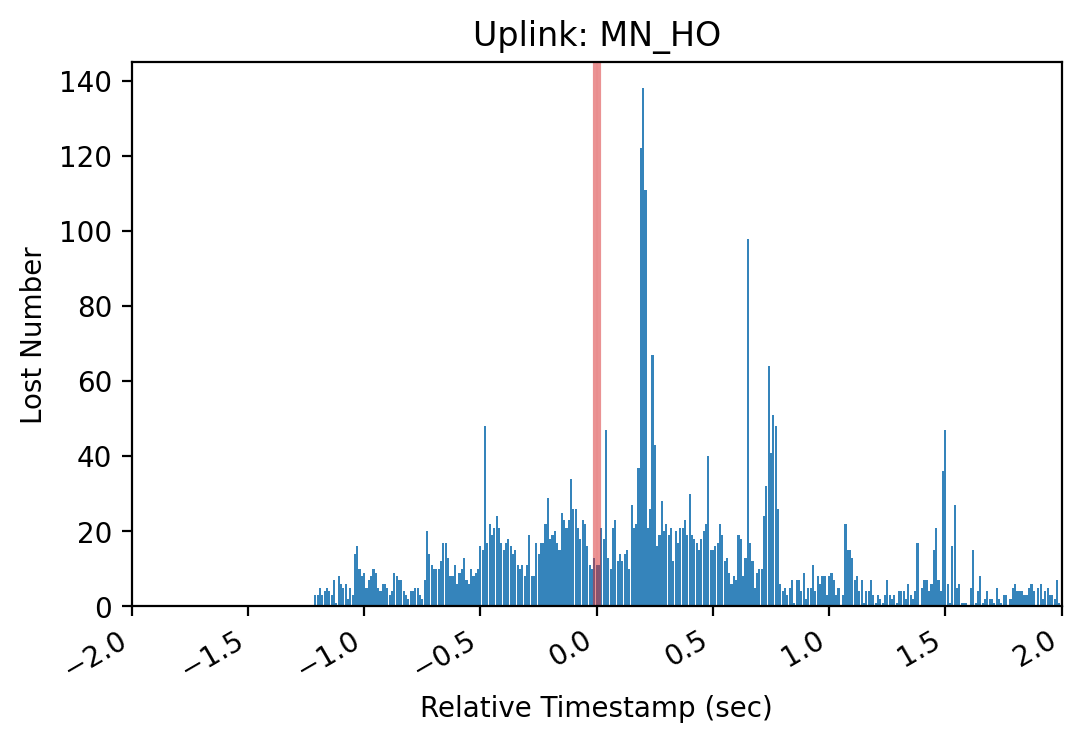

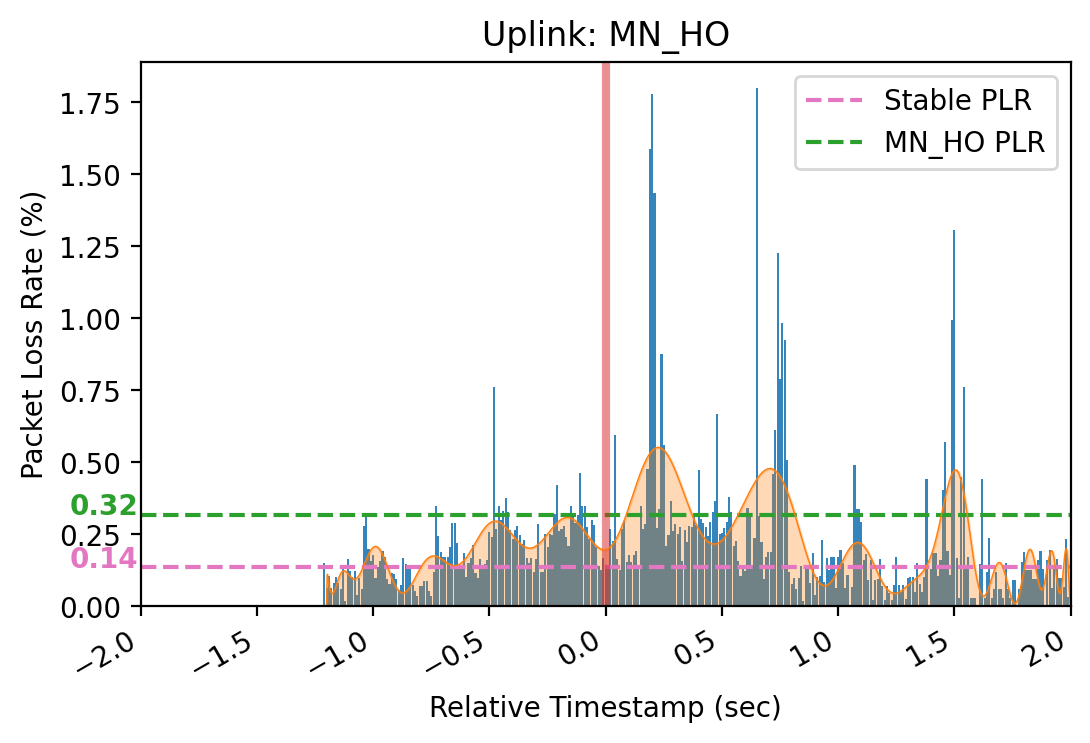

SN_HO
HO Count: 1775
Average Duration: 0.014759946468115693 seconds
Average PLR: 0.19614316509040033 %
Stable PLR: 0.13538547640672455 %


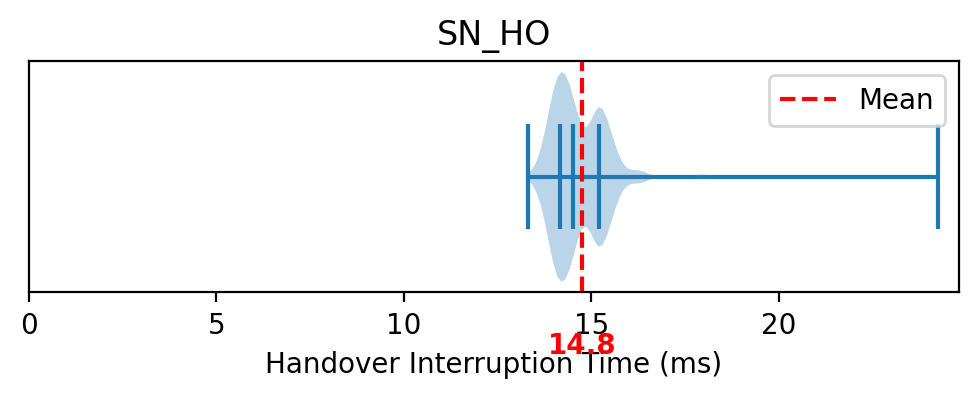

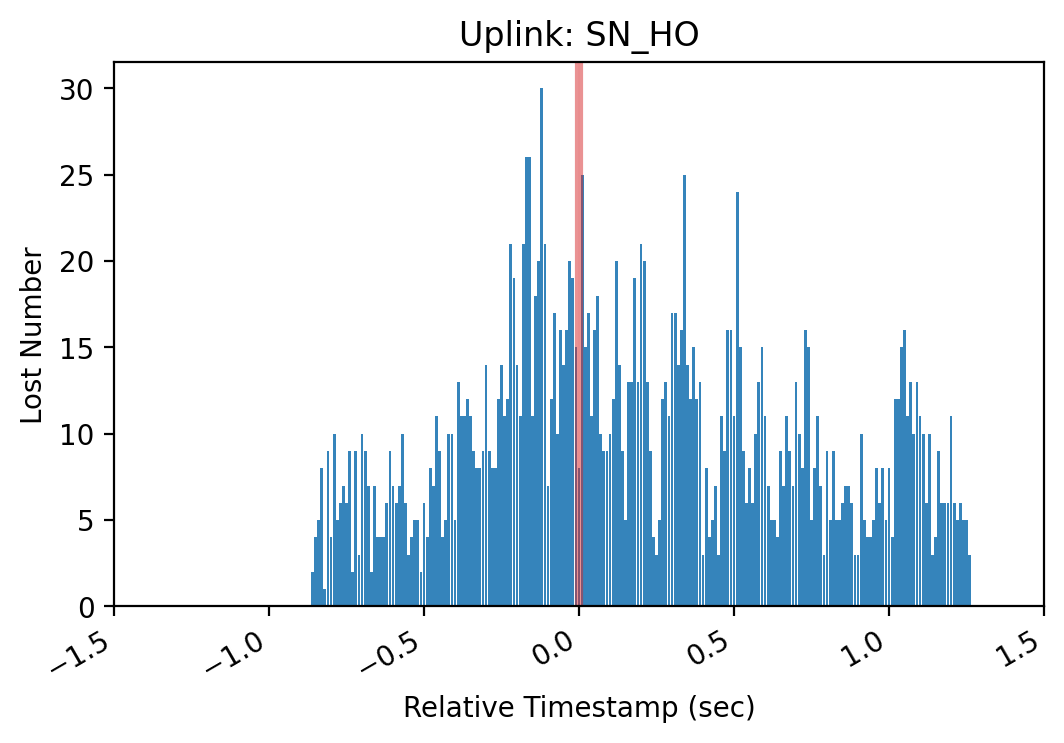

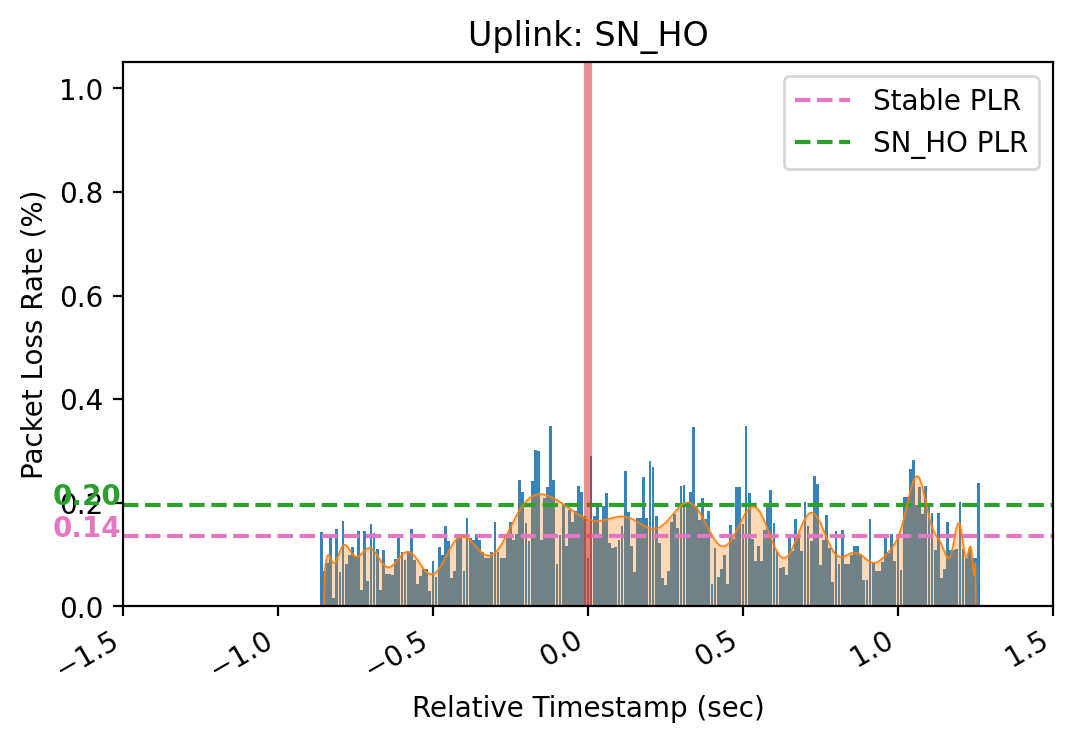

SN_Rel
HO Count: 11
Average Duration: 0.027407454411414536 seconds
Average PLR: 8.515283842776169 %
Stable PLR: 0.13538547640672455 %


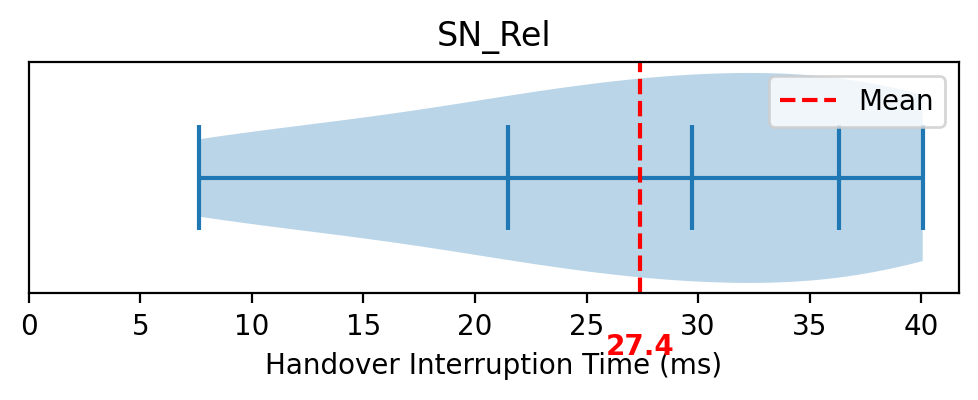

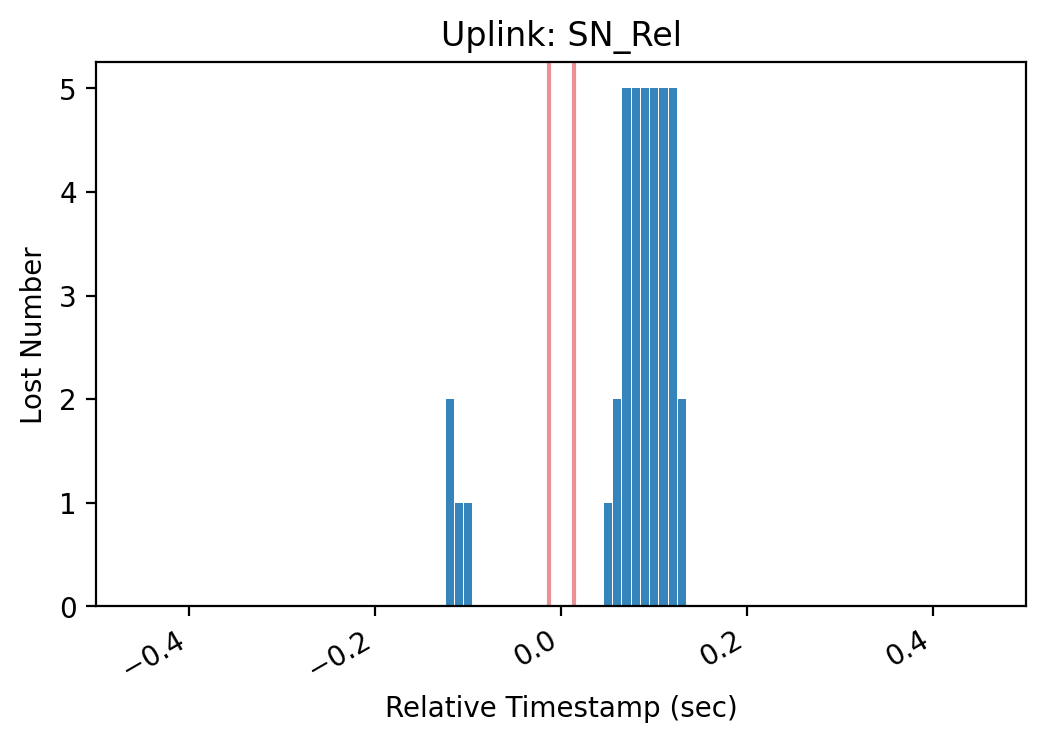

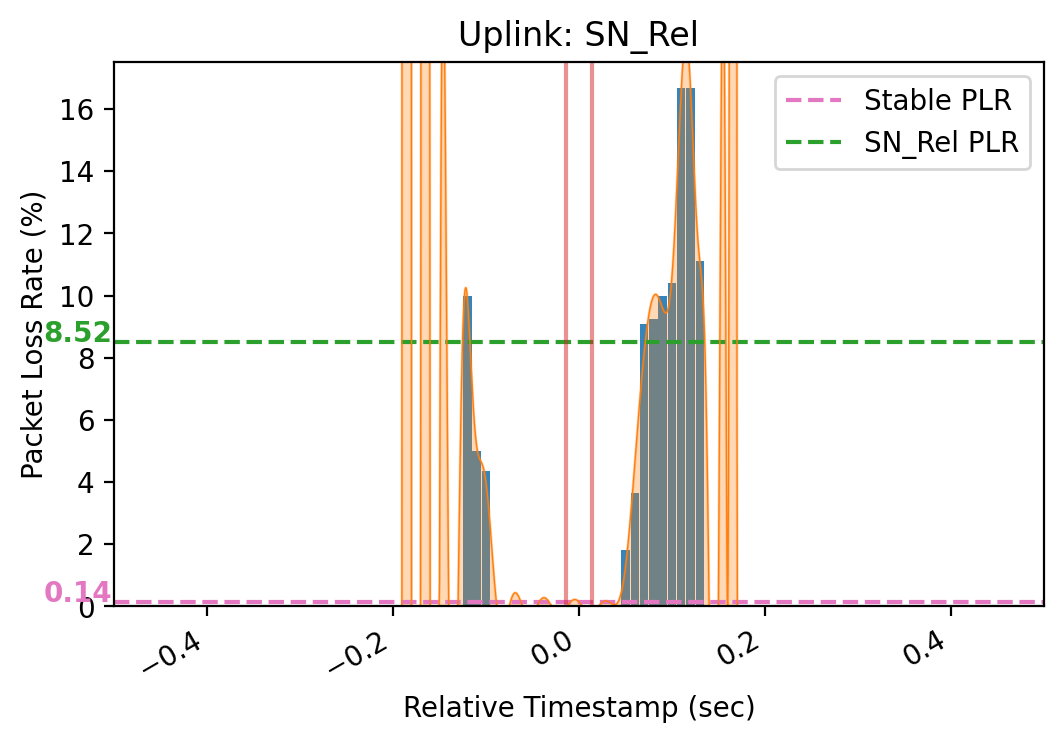

SN_Setup
HO Count: 445
Average Duration: 0.030301943838889345 seconds
Average PLR: 2.2167067823999815 %
Stable PLR: 0.13538547640672455 %


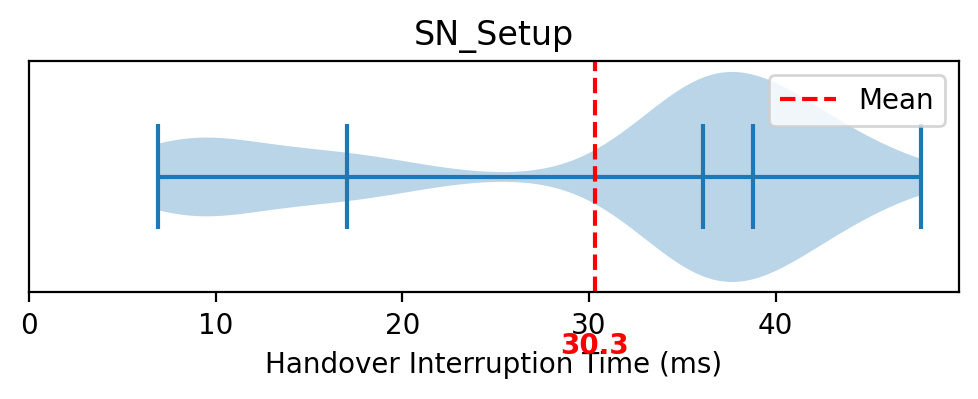

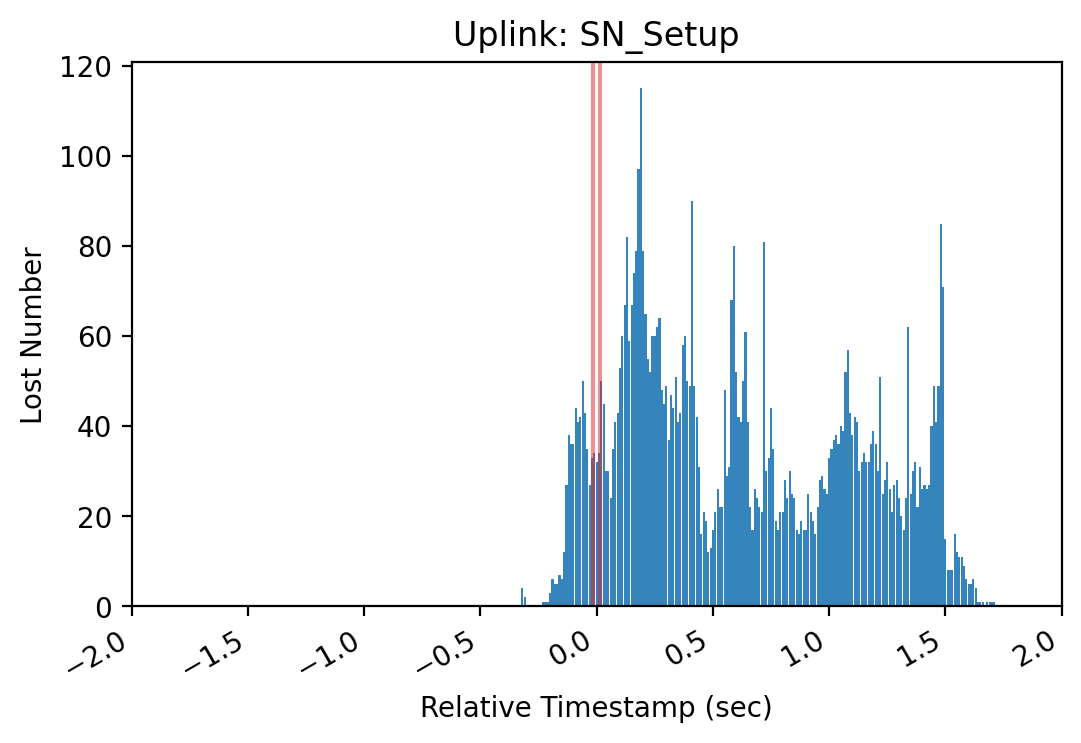

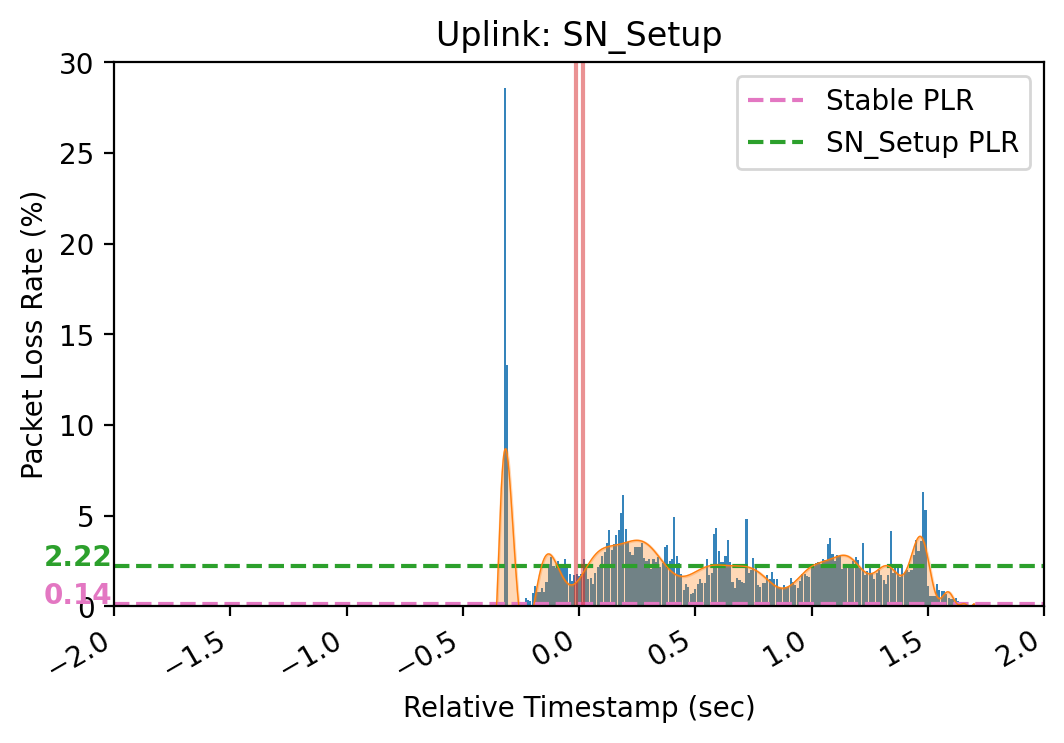

SN_Rel_MN_HO
HO Count: 233
Average Duration: 0.031081978471494028 seconds
Average PLR: 1.1521459152772058 %
Stable PLR: 0.13538547640672455 %


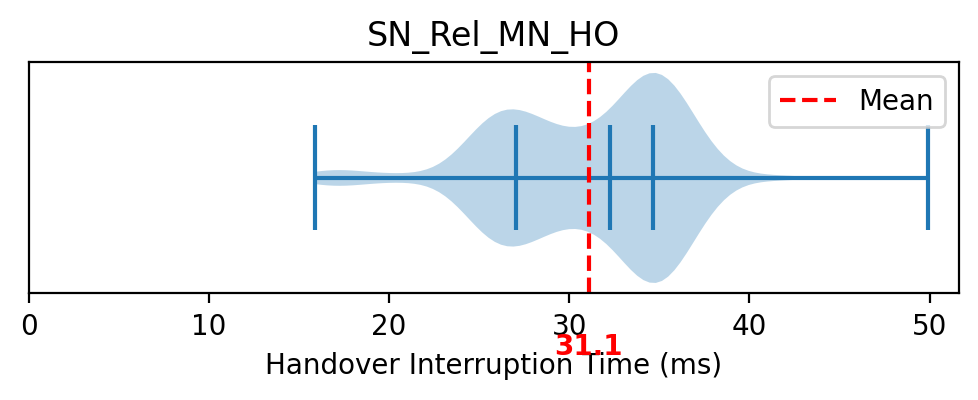

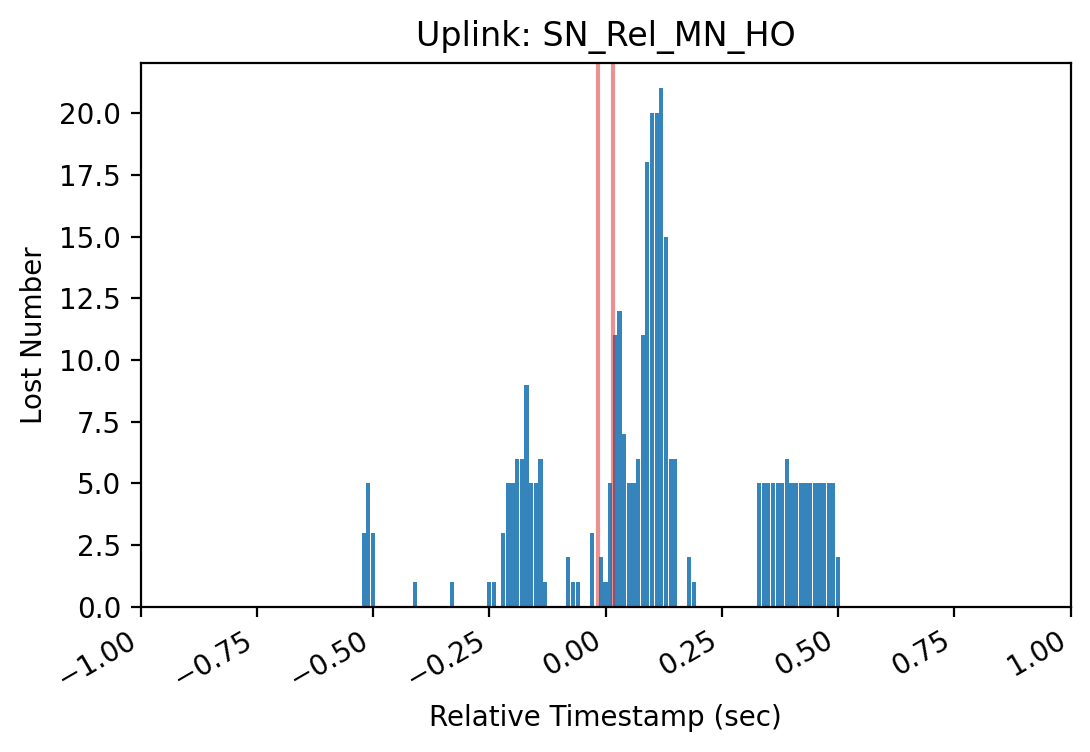

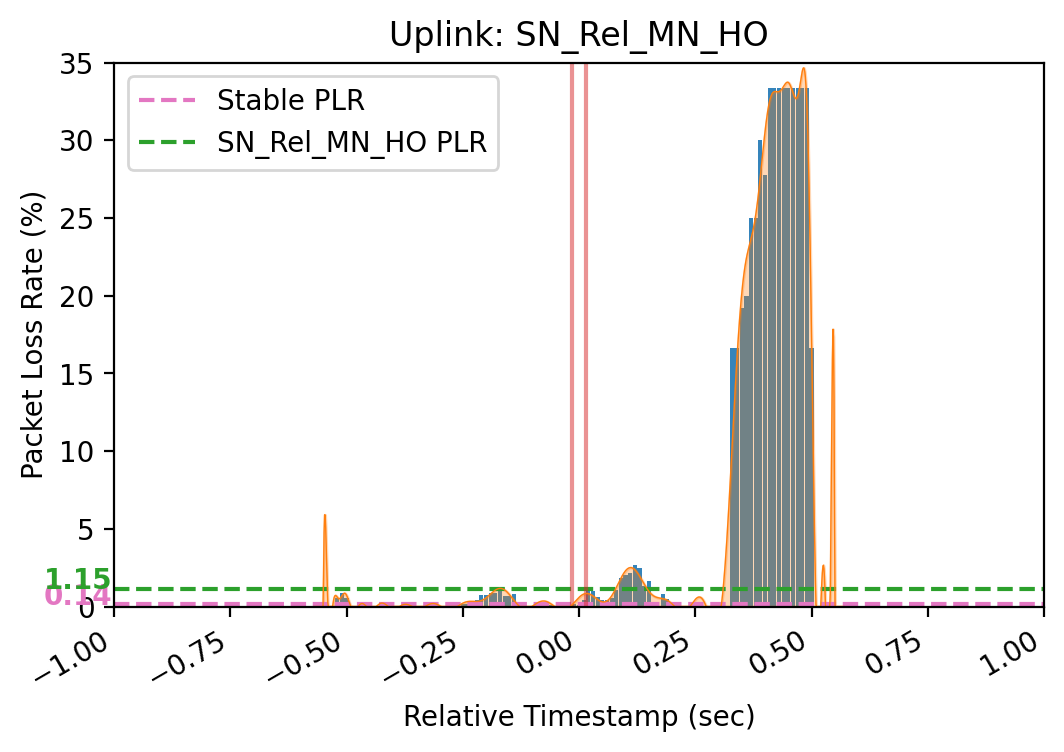

SCG_Failure_t310-Expiry (0)
HO Count: 3
Average Duration: 0.0 seconds
Average PLR: 95.78544061284332 %
Stable PLR: 0.13538547640672455 %


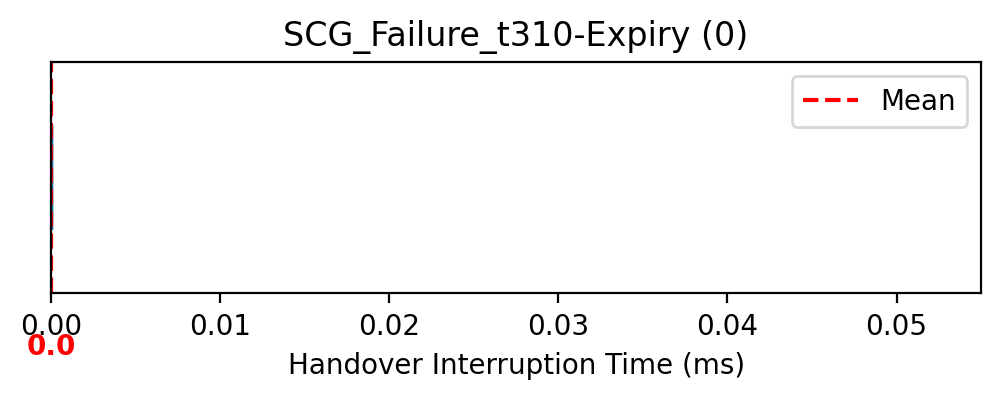

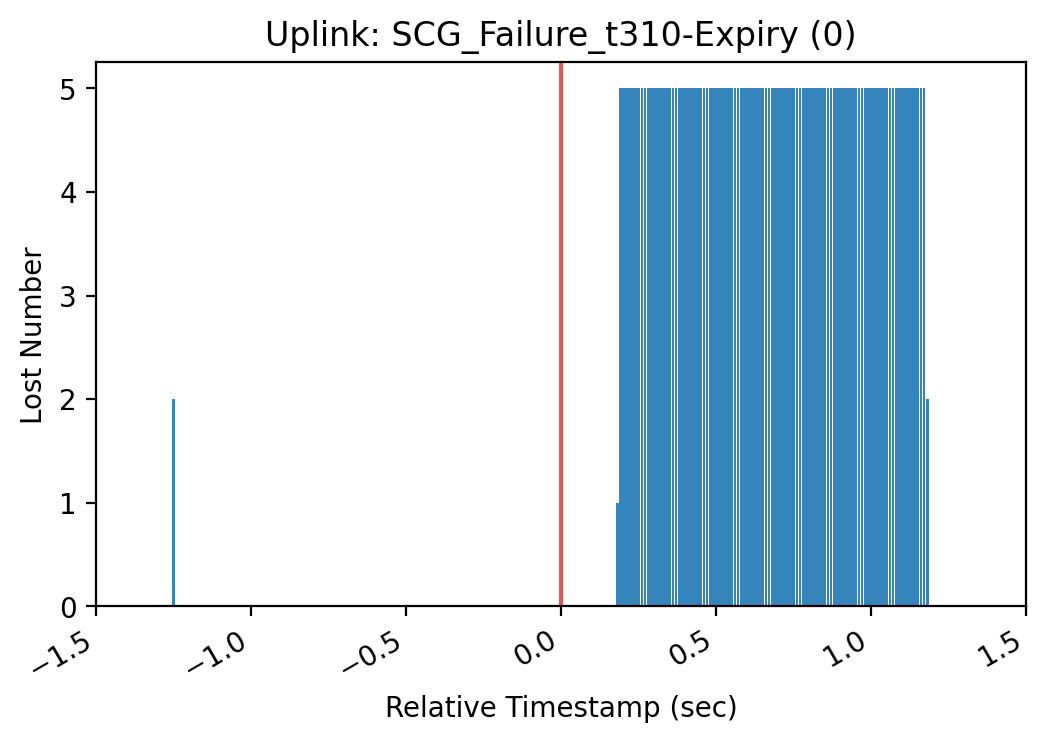

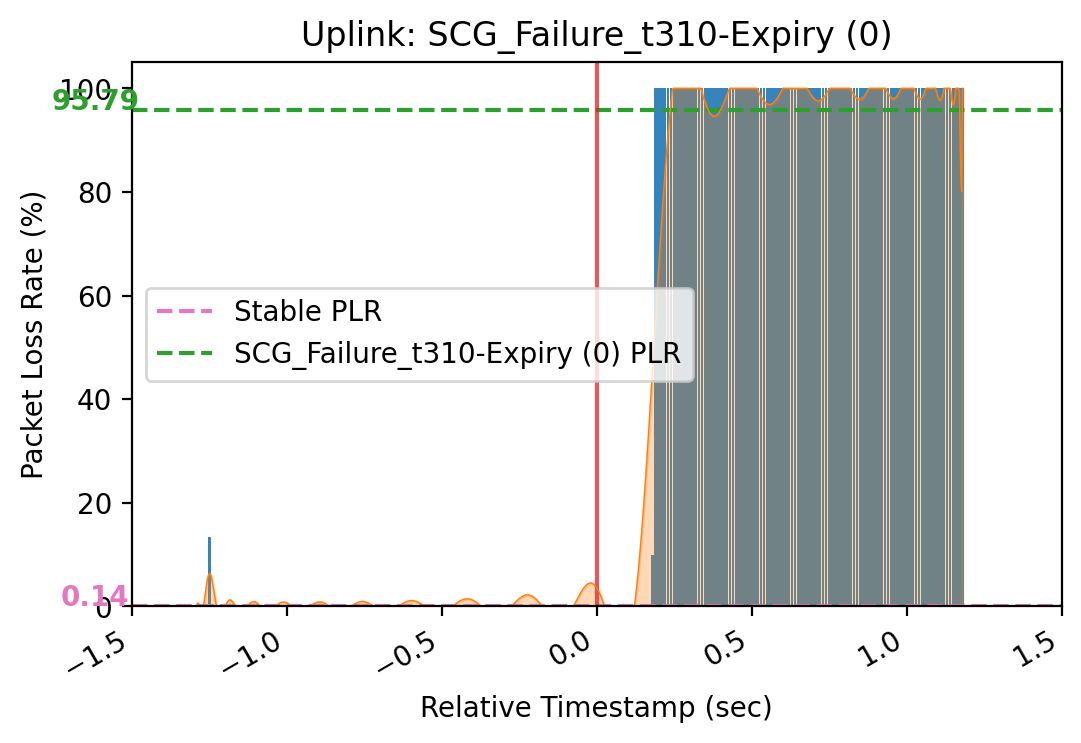

SCG_Failure_synchReconfigFailureSCG (3)
HO Count: 7
Average Duration: 0.0 seconds
Average PLR: 0.0 %
Stable PLR: 0.13538547640672455 %


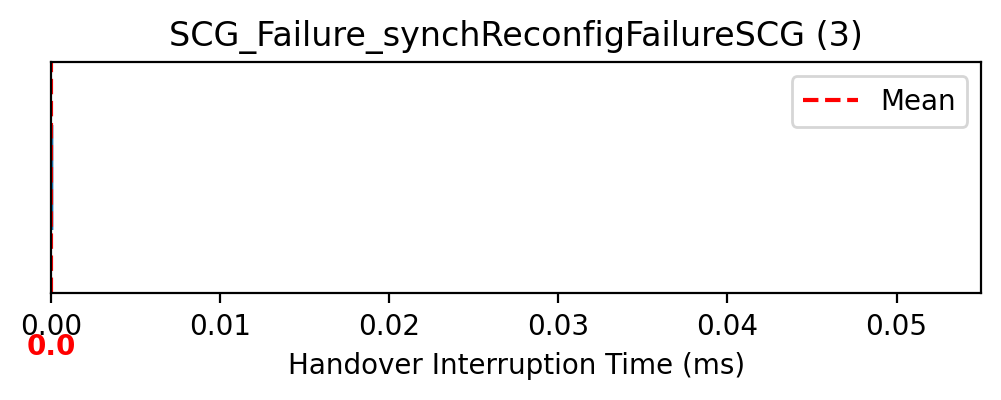

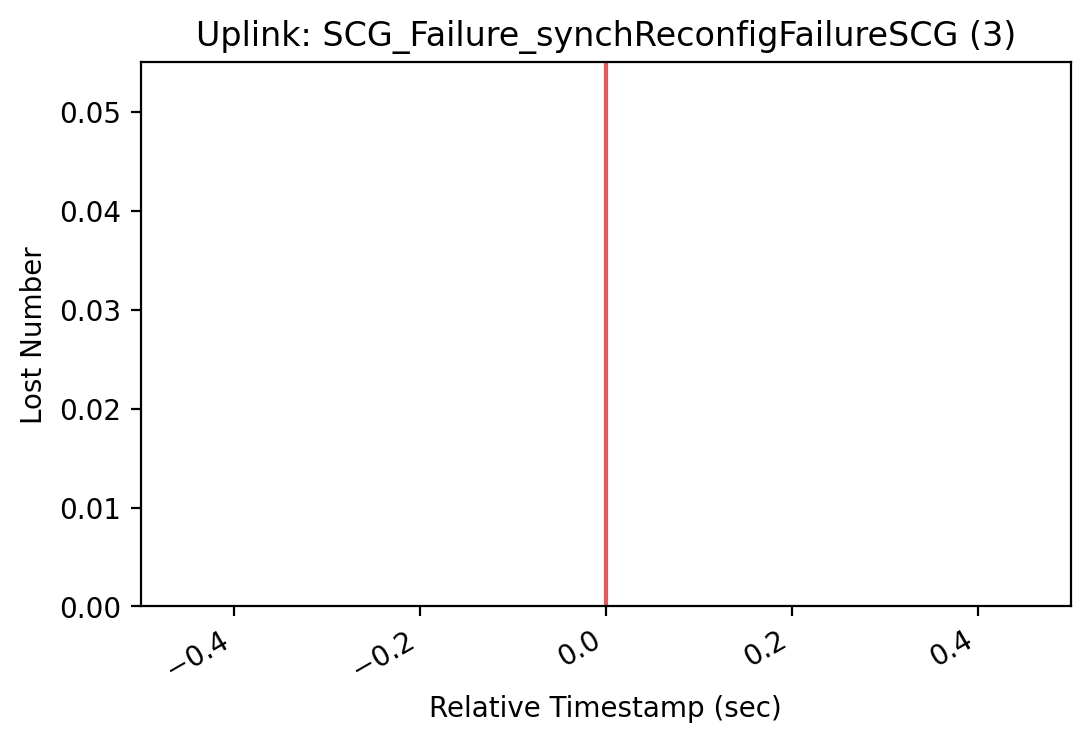

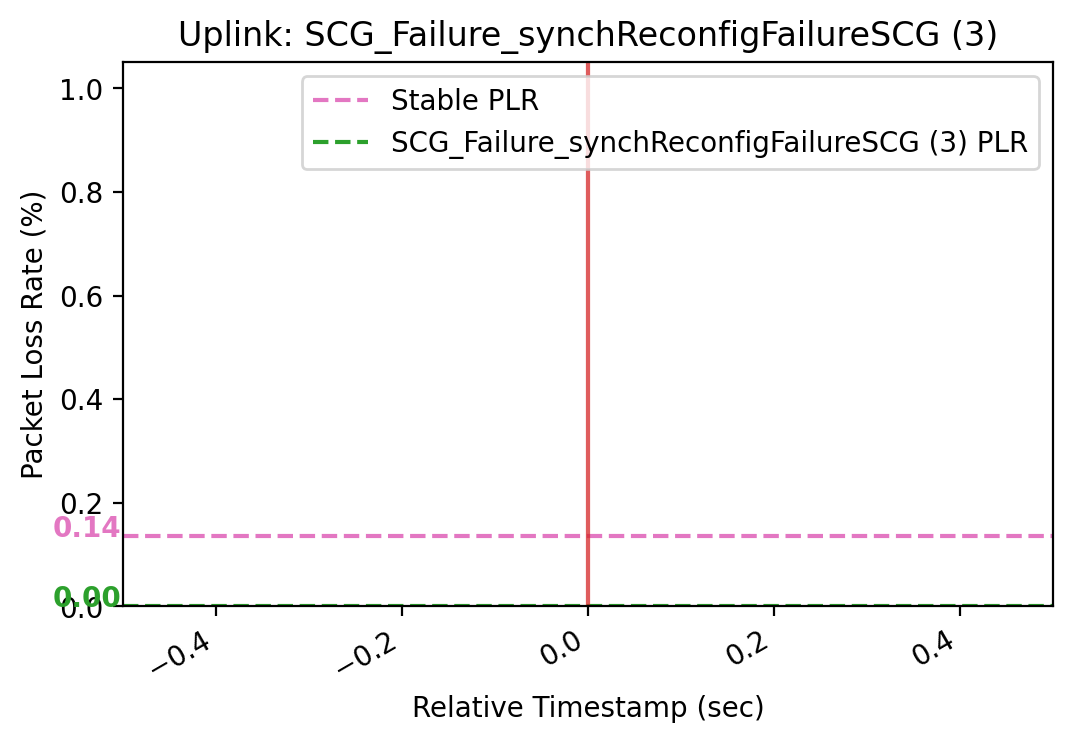

MCG_Failure_handoverFailure (1)
HO Count: 15
Average Duration: 0.08033413365483284 seconds
Average PLR: 2.5641025640916064 %
Stable PLR: 0.13538547640672455 %


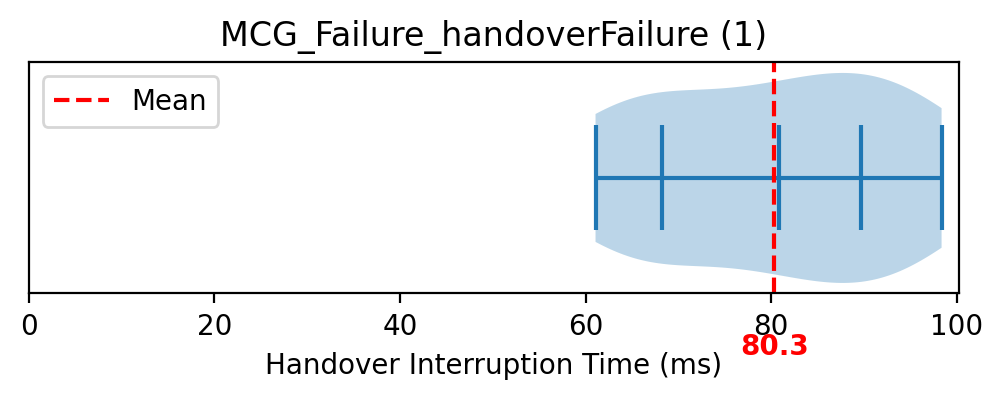

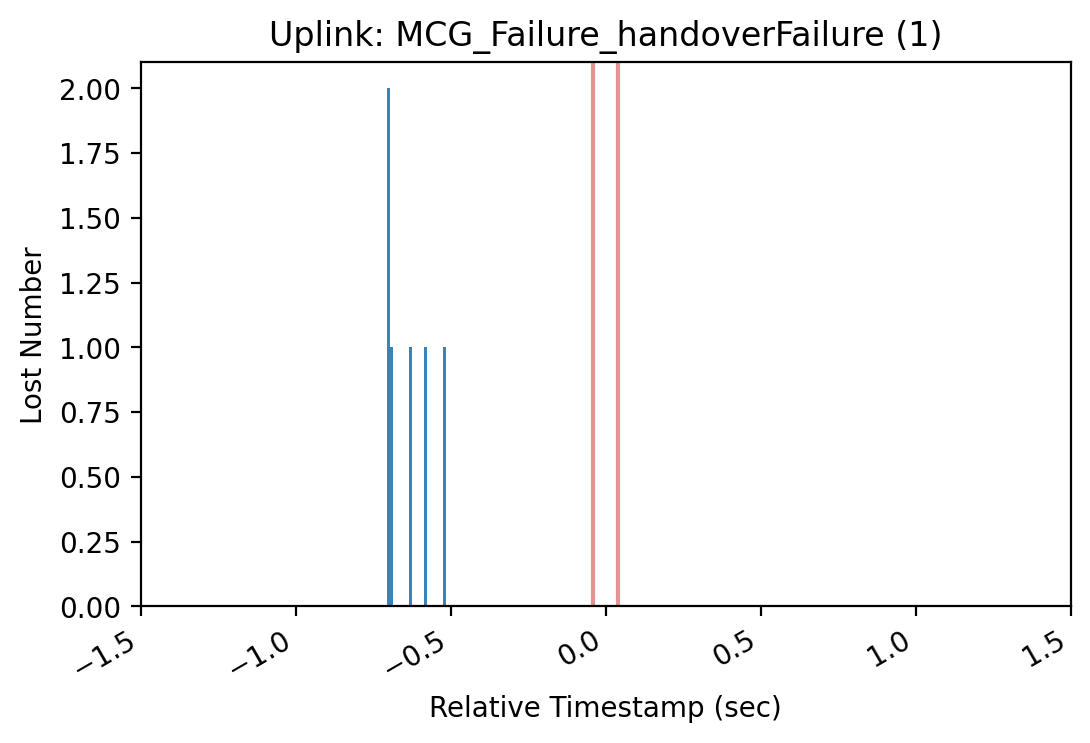

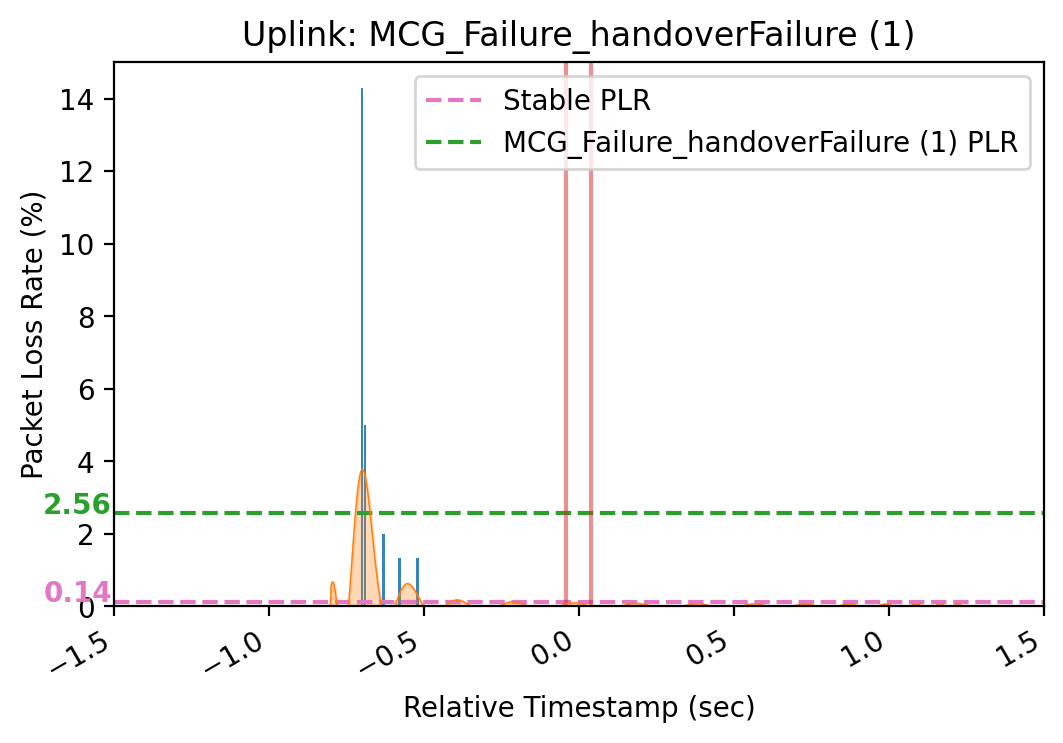

MCG_Failure_otherFailure (2)
HO Count: 214
Average Duration: 0.07793514952759877 seconds
Average PLR: 1.650413768988688 %
Stable PLR: 0.13538547640672455 %


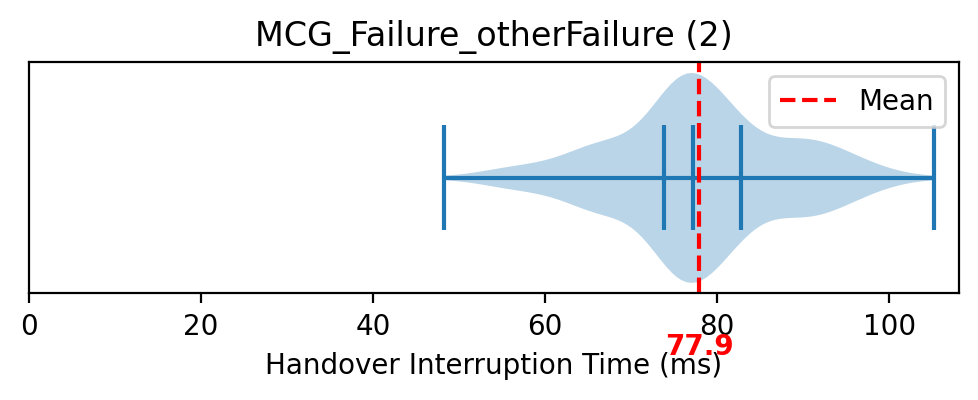

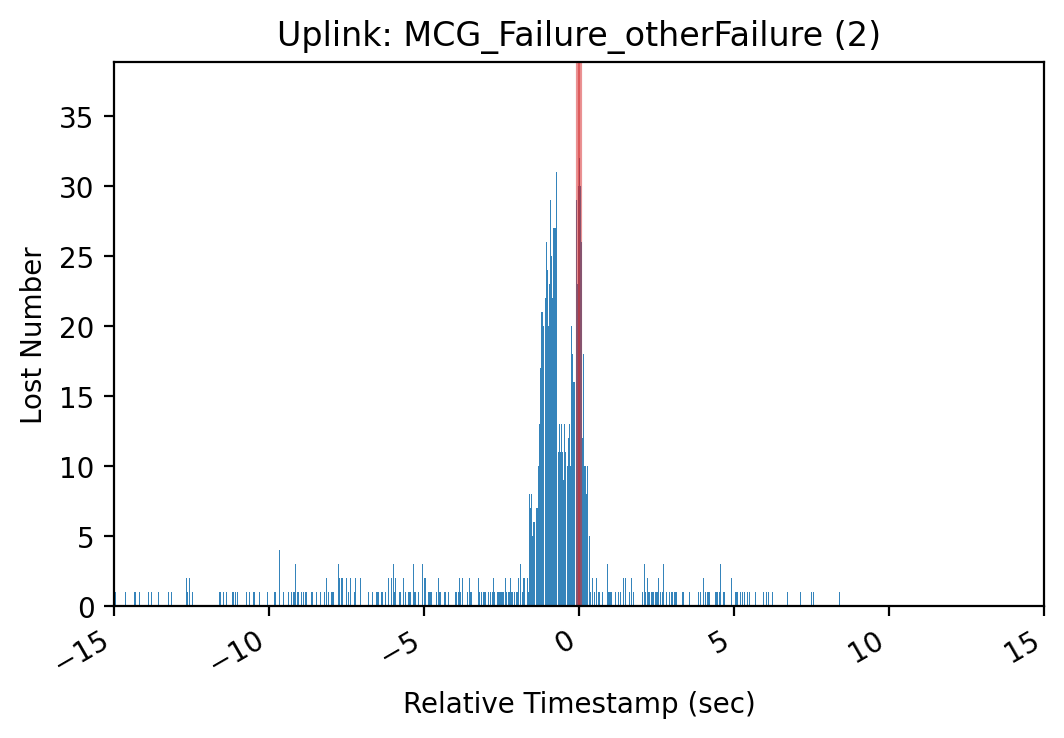

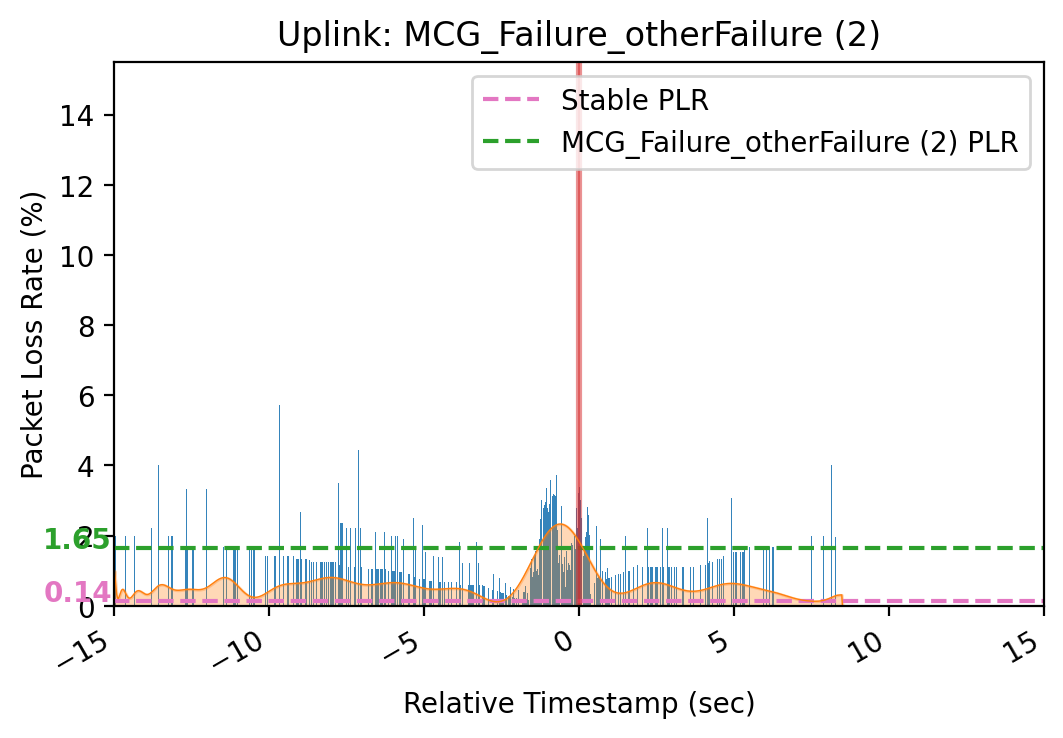

NAS_Recovery_otherFailure (2)
HO Count: 5
Average Duration: 0.3988637953996658 seconds
Average PLR: 22.074636306121395 %
Stable PLR: 0.13538547640672455 %


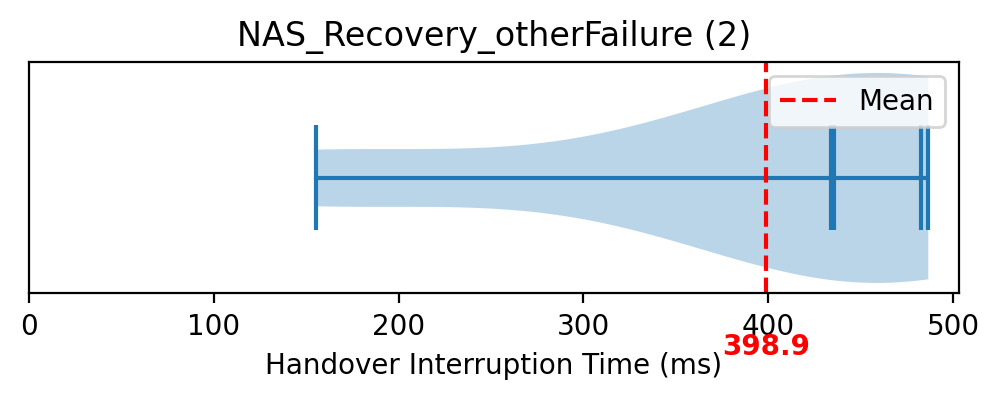

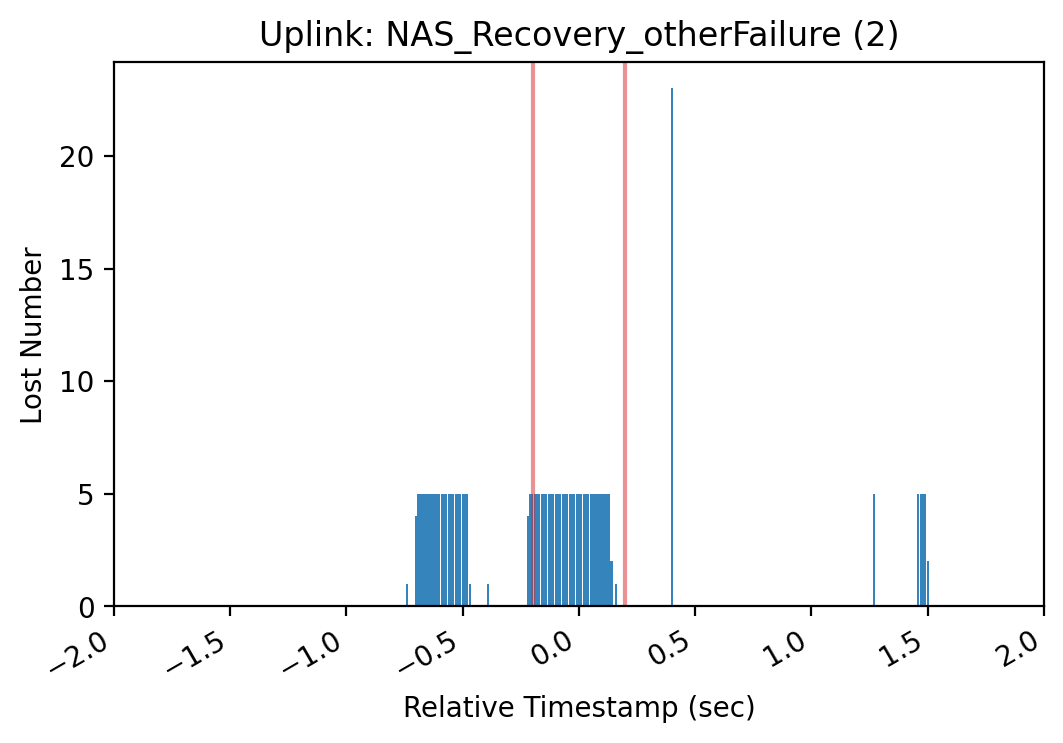

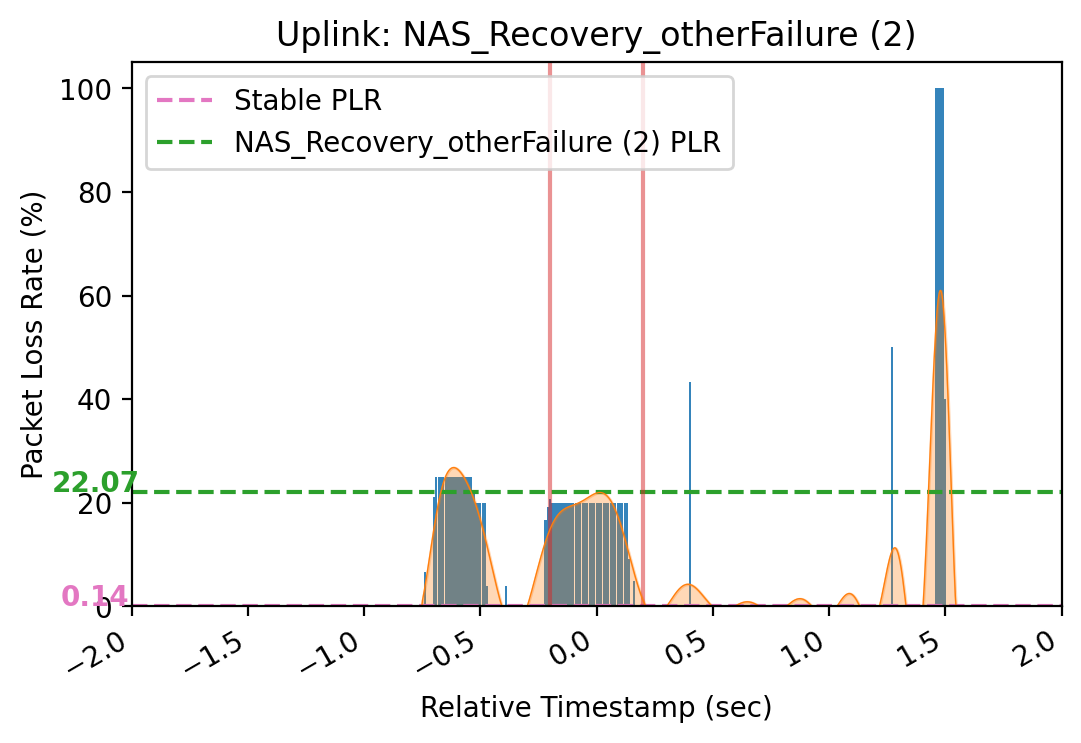

In [8]:
import warnings

def heaviside(x, left, right):
    if x < left:
        return 0
    elif x > right:
        return 0
    else:
        return 1

for tag in sorter:
    if len(U[tag]['intrs']) == 0:
        continue
    print('===================================')
    print(tag)
    table, intr = merge_profile(U[tag]['tables'], U[tag]['intrs'])
    print('HO Count:', sum(U[tag]['count']))
    print('Average Duration:', intr, 'seconds')
    # display(table)
    
    _table = table.query('PLR > @ul_stable_plr').copy().reset_index(drop=True)
    # _table = table.copy().reset_index(drop=True)
    tcount = sum(_table['tx_count'])
    lcount = sum(_table['lost'])
    plr = lcount / (tcount + 1e-9) * 100
    print('Average PLR:', plr, '%')
    print('Stable PLR:', ul_stable_plr, '%')
    
    path = './temp'
    plot_intrs(U[tag]['intrs'], tag, path=path)
    
    xlim = math.ceil(max([s*2 for s in ImpactScope[tag]])) / 2
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_title(f'Uplink: {tag}')
    ax.set_xlim(-xlim, xlim)
    ax.bar(table['cat_id'], table['lost'], width=0.009, alpha=0.9)
    ax.set_ylabel('Lost Number')
    ax.set_ylim(bottom=0)
    _intr = intr / 2
    ax.axvline(-_intr, color='tab:red', alpha=0.5)
    ax.axvline(_intr, color='tab:red', alpha=0.5)
    ax.set_xlabel('Relative Timestamp (sec)')
    plt.gcf().autofmt_xdate()
    plt.savefig(os.path.join(path, f'{tag}_UL_lost.png'), bbox_inches='tight', dpi=300)
    plt.show()
    
    
    xlim = math.ceil(max([s*2 for s in ImpactScope[tag]])) / 2
    # plot_profile(table1, intr=intr1, title=tag, mode='plr', xlim=wsize, path=path, flow='dl', stable_plr=stable_plr, plr=plr, plr1=plr1)
    xlim = math.ceil(max([s*2 for s in ImpactScope[tag]])) / 2
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_title(f'Uplink: {tag}')
    ax.set_xlim(-xlim, xlim)
    ax.bar(table['cat_id'], table['PLR'], width=0.009, alpha=0.9)
    ax.set_ylabel('Packet Loss Rate (%)')
    ax.set_ylim(bottom=0)
    if ax.get_ylim()[1] < 1:
        ax.set_ylim(top=1.05)
    
    ax.axhline(ul_stable_plr, color='tab:pink', linestyle='--', label='Stable PLR')
    ax.text(-1.078*xlim, ul_stable_plr, '{:.2f}'.format(ul_stable_plr), ha='center', fontweight='bold', fontsize=10, color='tab:pink')
    ax.axhline(plr, color='tab:green', linestyle='--', label=f'{tag} PLR')
    ax.text(-1.078*xlim, plr, '{:.2f}'.format(plr), ha='center', fontweight='bold', fontsize=10, color='tab:green')
    ax.legend()
    bleft = -ImpactScope[tag][0]
    bright = ImpactScope[tag][1]
    
    _intr = intr / 2
    ax.axvline(-_intr, color='tab:red', alpha=0.5)
    ax.axvline(_intr, color='tab:red', alpha=0.5)
    ax.set_xlabel('Relative Timestamp (sec)')
    
    x = np.asarray(table['cat_id'], dtype=np.float64)
    y = np.asarray(table['PLR'], dtype=np.float64)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', np.RankWarning)
        z = np.polyfit(x, y, 70)
        p = np.poly1d(z)
    xp = np.linspace(table['cat_id'].iloc[0], table['cat_id'].iloc[-1], 1000)
    
    ax.plot(xp, np.clip(p(xp)*np.vectorize(heaviside)(xp, bleft, bright), a_min=0, a_max=100), '-', c='tab:orange', lw=0.5)
    ax.fill_between(xp, np.clip(p(xp)*np.vectorize(heaviside)(xp, bleft, bright), a_min=0, a_max=100), color='tab:orange', alpha=0.3)
    
    plt.gcf().autofmt_xdate()
    plt.savefig(os.path.join(path, f'{tag}_UL_PLR.png'), bbox_inches='tight', dpi=300)
    plt.show()